In [1]:
%matplotlib notebook
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.misc import derivative
import datetime
import time

import pandas as pd


!pip install -q -U keras-tuner

import keras_tuner
import keras.backend
import keras.callbacks
from keras_tuner.engine.hyperparameters import HyperParameters


#machine learning:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve


import tensorflow as tf
from tensorflow import keras



#smoothing functions:
from scipy.signal import butter,filtfilt
import scipy.signal
from astropy.convolution import convolve, Box1DKernel

## Load 2004 Data:

In [2]:
#Joe Stroud#
import pandas as pd

#Importing Cassini data with labels
df = pd.read_csv('2004_FGM_KSM_1M.TAB', delimiter = '\\s+', names = ['Time', 'Bx', 'By', 'Bz', 'BTotal', 'X', 'Y', 'Z', 'Local Hour', 'NPTS'])

In [3]:
#Importing 2005 Cassini data with labels
df05 = pd.read_csv('2005_FGM_KSM_1M.TAB', delimiter = '\\s+', names = ['Time', 'Bx', 'By', 'Bz', 'BTotal', 'X', 'Y', 'Z', 'Local Hour', 'NPTS'])

In [3]:
df

,Time,Bx,By,Bz,BTotal,X,Y,Z,Local Hour,NPTS
0,2004-05-11T00:00:30,0.061,0.142,-0.041,0.161,172.297,-404.888,-57.532,7.2,-1
1,2004-05-11T00:01:30,0.065,0.149,-0.039,0.169,172.295,-404.884,-57.524,7.2,-1
2,2004-05-11T00:02:30,0.072,0.137,-0.040,0.161,172.293,-404.880,-57.516,7.2,-1
3,2004-05-11T00:03:30,0.078,0.138,-0.036,0.163,172.291,-404.876,-57.509,7.2,-1
4,2004-05-11T00:04:30,0.071,0.143,-0.034,0.164,172.288,-404.872,-57.501,7.2,-1
...,...,...,...,...,...,...,...,...,...,...
312254,2004-12-31T23:55:30,-0.111,-0.390,-0.191,0.449,19.435,-56.256,3.744,7.3,60
312255,2004-12-31T23:56:30,-0.116,-0.391,-0.204,0.457,19.436,-56.255,3.744,7.3,60
312256,2004-12-31T23:57:30,-0.138,-0.379,-0.209,0.455,19.437,-56.255,3.745,7.3,60
312257,2004-12-31T23:58:30,-0.134,-0.376,-0.200,0.447,19.438,-56.254,3.745,7.3,60


## Load and Format Crossings from A. Master's Paper:

In [4]:
#Juan Jose#
#Import Adam's paper's crossings
bs_crossings = pd.read_csv('Crossings_from_Adam_reduced_final.csv',delimiter = ',', usecols = [1,5,6,7,8,9,10])

bs_crossings
#Add Time column
bs_crossings_Time = np.ones(len(bs_crossings))
bs_crossings.insert(1,"Time",bs_crossings_Time, True)

#Add Type of Crossing
#bs_crossings_Type = np.ones(len(bs_crossings))
#bs_crossings_Type[1::2] = 0
#bs_crossings.insert(1,"Type",bs_crossings_Type, True)
bs_crossings

,Year,Time,Day of Year,Time (UT),X,Y,Z,Type
0,2004,1.0,179,946,22.4,-43.5,-4.4,1
1,2004,1.0,179,1028,22.3,-43.2,-4.3,0
2,2004,1.0,179,1804,21.1,-40.2,-3.8,1
3,2004,1.0,179,2000,20.8,-39.4,-3.7,0
4,2004,1.0,180,18,20.1,-37.6,-3.4,1
...,...,...,...,...,...,...,...,...
192,2005,1.0,223,46,14.5,-37.8,-3.8,1
193,2005,1.0,223,314,14.7,-37.7,-3.8,0
194,2005,1.0,223,630,15.0,-37.6,-3.8,1
195,2005,1.0,223,1815,16.0,-37.2,-3.8,0


In [5]:
#Juan Jose#
#CSV had something wrong in the formatting so I had to fix it
for i, data_point in bs_crossings.iterrows():

    Year = str(int(data_point["Year"]))
    DayofYear = str(int(data_point["Day of Year"]))
    UT = str(int(data_point["Time (UT)"]))
    
    #Fill DaysofYear points with missing 0s
    if len(DayofYear) == 2:
        DayofYear = "0" + DayofYear
        
    elif len(DayofYear) == 1:
        DayofYear = "00" + DayofYear
    
    #Fill UT points with missing 0s
    if len(UT) == 3:
        UT = "0" + UT
        
    elif len(UT) == 2:
        UT = "00" + UT
    
    elif len(UT) == 1:
        UT = "000" + UT
    
    #Split UT into hours and minutes
    hour = UT[0:2]    
    minute = UT[2:4]
    
    #Put the appropriate formatting together for the functions
    time = Year + "-" + DayofYear + "T" + hour + ":" + minute + ":30"
    
    #Substitute into dataframe
    bs_crossings.loc[i,"Time"] = time

In [6]:
bs_crossings

,Year,Time,Day of Year,Time (UT),X,Y,Z,Type
0,2004,2004-179T09:46:30,179,946,22.4,-43.5,-4.4,1
1,2004,2004-179T10:28:30,179,1028,22.3,-43.2,-4.3,0
2,2004,2004-179T18:04:30,179,1804,21.1,-40.2,-3.8,1
3,2004,2004-179T20:00:30,179,2000,20.8,-39.4,-3.7,0
4,2004,2004-180T00:18:30,180,18,20.1,-37.6,-3.4,1
...,...,...,...,...,...,...,...,...
192,2005,2005-223T00:46:30,223,46,14.5,-37.8,-3.8,1
193,2005,2005-223T03:14:30,223,314,14.7,-37.7,-3.8,0
194,2005,2005-223T06:30:30,223,630,15.0,-37.6,-3.8,1
195,2005,2005-223T18:15:30,223,1815,16.0,-37.2,-3.8,0


In [6]:
#Convert from YYYY-MM-DD format into YYYY-DDD:
def day_of_year(array):
    """Converts an array of dates in the YYYY-MM-DD format into YYYY-DDD
    Note this rewrites the input array so be careful"""
    
    for i, value in enumerate(array):
        
        #Separate components of the date
        Y = int(value[0:4])
        M = int(value[5:7])
        D = int(value[8:10])
        
        #Convert to date format
        date = datetime.date(day = D, month = M, year = Y)
        #Extract day of the year
        day_of_year = date.strftime('%j')
        
        #Replace MM-DD with the day of the year
        array[i] = value.replace(value[5:10],day_of_year)
        
    return(array)

#convert
df_times = np.array(df['Time'])
df_times = day_of_year(df_times)
time = day_of_year(np.array(df['Time']))
bs_crossings['Time']

fix = []
for time in bs_crossings['Time']:
    if time in df_times:
        fix.append(1)

#final format:
bs_crossings['Time']

0      2004-179T09:46:30
1      2004-179T10:28:30
2      2004-179T18:04:30
3      2004-179T20:00:30
4      2004-180T00:18:30
             ...        
192    2005-223T00:46:30
193    2005-223T03:14:30
194    2005-223T06:30:30
195    2005-223T18:15:30
196    2005-224T13:31:30
Name: Time, Length: 197, dtype: object

## Functions to Format Plot Time:

When plotting the time on the x-axis it is in the YYYY-MM-DD-TTTT format. It's preferable to only include MM-DD-TTTT. Also, since there are many points on the timeline (30 second intervals) we want to increase the interal spacing to allow for a clear view of the times.

In [7]:
#Juan Jose Juan Castella
#Tick pacing function
def tick_pace(x_array, pace):
    """Lets you pick every how many array indeces you want an x tick on your plot. 
    You input the array and a pace number (every how many indeces you want an xtick).
    
    It returns an array with the index positions in the original array that correspond to the x ticks
    and the array with the values at the tick positions
    
    Apply by using plt.xticks(ticks = tick_pace(your_x_array,your_pace)[0], labels = tick_pace(your_x_array,your_pace)[1])"""
    
    #Find length of array
    n = len(x_array)
    #Index array
    index = np.arange(0,n,1)
    #Pick every "pace" values of the index array
    index = index[0:n+1:pace]
    x_array_cut = x_array[0:n+1:pace]
    
    return index, x_array_cut



def remove_year(t_array):
    """Removes the year in an array of time measurements to make x-axes on plots of readings within the same year 
    more easy to display"""
    
    #Return array
    t_output = np.array([])
    
    for value in t_array:
        #Slice the year part off the string
        sliced_value = value[5:]
        #Append to our return
        t_output = np.append(t_output,sliced_value)
    return t_output

## Plot Crossings for Training:

In [8]:
#Joe Stroud#
#assigning variables for 2004 data:
time1 = np.array(df['Time'])
time = day_of_year(np.array(df['Time'])) #day of the year format
Bx = df['Bx']
By = df['By']
Bz = df['Bz']
BTotal = df['BTotal']
X = df['X']
Y = df['Y']
Z = df['Z']
Local_hour = df['Local Hour']
NPTS = df['NPTS']



#assigning variables for 2005 data:
time05 = day_of_year(np.array(df05['Time'])) #day of the year format
Bx05 = df05['Bx']
By05 = df05['By']
Bz05 = df05['Bz']
BTotal05 = df05['BTotal']
X05 = df05['X']
Y05 = df05['Y']
Z05 = df05['Z']
Local_hour05 = df05['Local Hour']
NPTS05 = df05['NPTS']

Use November crossings data for training neural network since there are many distinct crossings which will train the neural network well. 

<IPython.core.display.Javascript object>


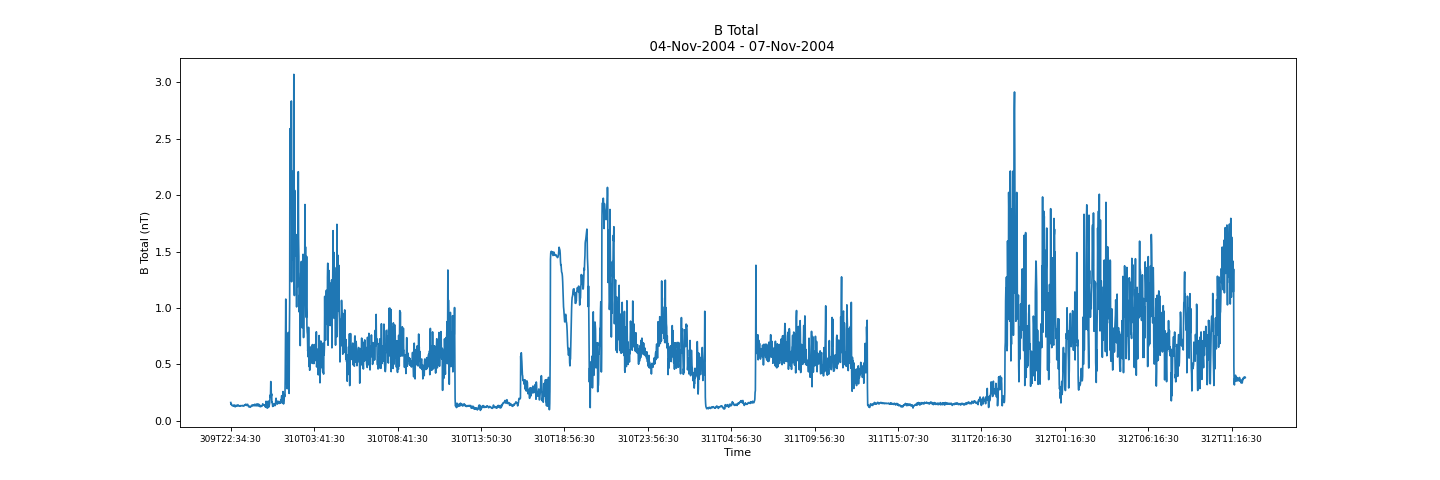

In [10]:
plt.figure(figsize=(18, 6))
plt.plot(time[232500:236150], BTotal[232500:236150], label="Data")

plt.title('B Total \n  04-Nov-2004 - 07-Nov-2004')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')

#plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time[232420:236150],60*5)[0],
           labels = remove_year(tick_pace(time[232420:236150],60*5)[1]), fontsize= 8)

plt.show()

## Normalise Data:

<IPython.core.display.Javascript object>


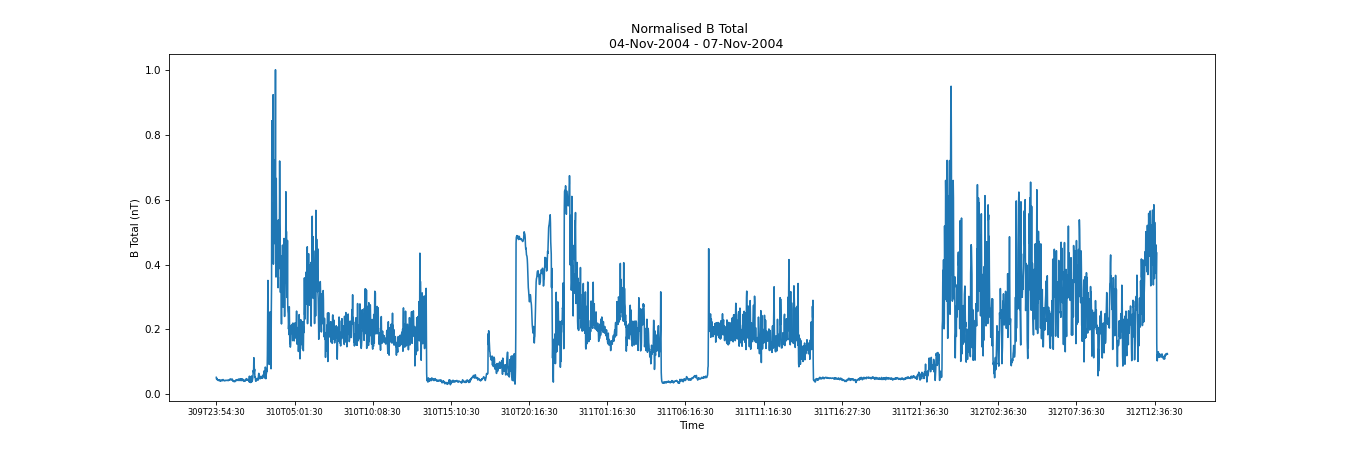

In [9]:
def norm(data):
    '''Normalised data
    Input: data
    Output: normalised data
    '''
    return data/np.amax(data) #divide by max value

#plot the normalised data:
plt.figure(figsize=(18, 6))
plt.plot(time[232500:236150], norm(BTotal[232500:236150]))
plt.title('Normalised B Total \n  04-Nov-2004 - 07-Nov-2004')

#format x-axis time:
plt.xticks(ticks=tick_pace(time[232500:236150],60*5)[0],
           labels = remove_year(tick_pace(time[232500:236150],60*5)[1]), fontsize= 8)

plt.xlabel('Time')
plt.ylabel('B Total (nT)')
plt.show()

In [10]:
bs_crossings

,Year,Time,Day of Year,Time (UT),X,Y,Z,Type
0,2004,2004-179T09:46:30,179,946,22.4,-43.5,-4.4,1
1,2004,2004-179T10:28:30,179,1028,22.3,-43.2,-4.3,0
2,2004,2004-179T18:04:30,179,1804,21.1,-40.2,-3.8,1
3,2004,2004-179T20:00:30,179,2000,20.8,-39.4,-3.7,0
4,2004,2004-180T00:18:30,180,18,20.1,-37.6,-3.4,1
...,...,...,...,...,...,...,...,...
192,2005,2005-223T00:46:30,223,46,14.5,-37.8,-3.8,1
193,2005,2005-223T03:14:30,223,314,14.7,-37.7,-3.8,0
194,2005,2005-223T06:30:30,223,630,15.0,-37.6,-3.8,1
195,2005,2005-223T18:15:30,223,1815,16.0,-37.2,-3.8,0


## Label-Obtaining Function:

In [10]:
#labels via constant threshold method:
def label(time):
    '''Labels for the NN (the values, for the data, the NN has to get to)
    Inputs: time (the timeframe of labels wanted)
    Outputs: labels (either 0 or 1) at different points in orbit
    '''
    labfix = []
    counter = 1

    for i in time:
        

        for k in bs_crossings['Time']:
            if k == i:
                counter += 1    

 
        if (-1)**counter == -1:
            labfix.append(0)
        elif (-1)**counter == 1:
            labfix.append(1)
    

            
    return labfix

In [74]:
print(label(time[232100:236150]))

[0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
labels_2004 = label(time)
labels_2005 = label(time05)

<IPython.core.display.Javascript object>


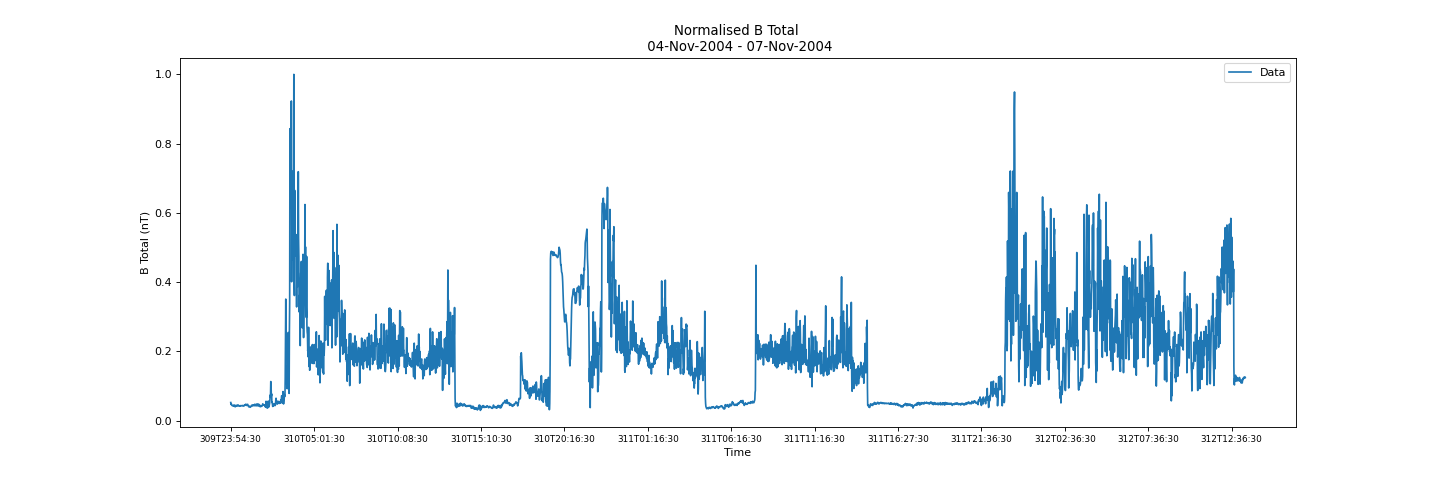

<IPython.core.display.Javascript object>


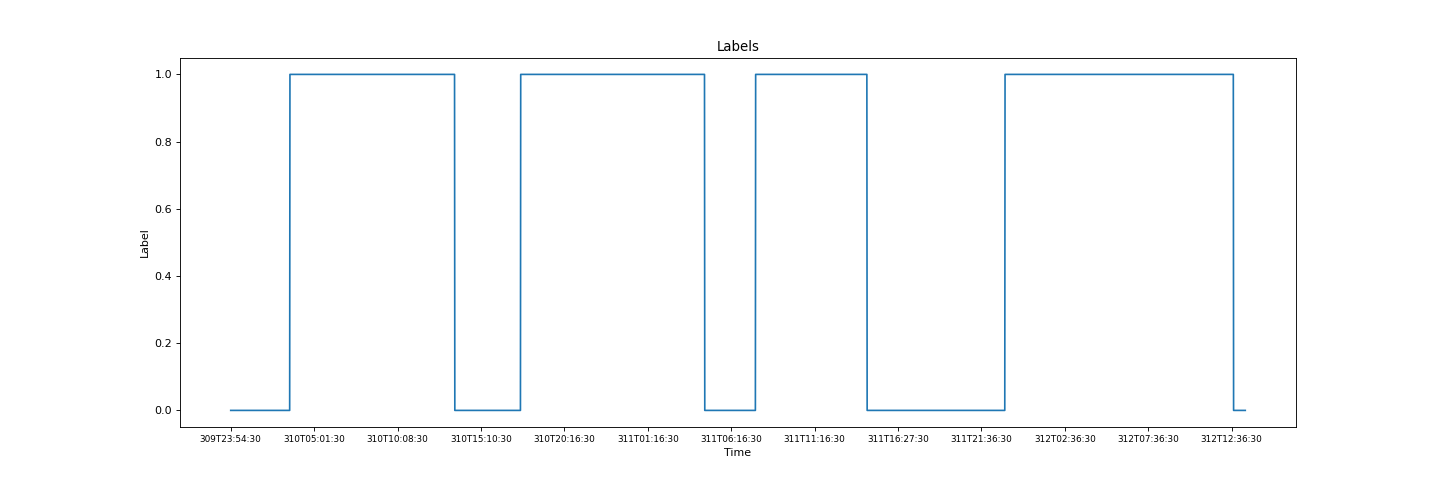

In [12]:
#plot the normalised data:
plt.figure(figsize=(18, 6))
plt.plot(time[232500:236150], norm(BTotal[232500:236150]), label="Data")
plt.title('Normalised B Total \n 04-Nov-2004 - 07-Nov-2004')
plt.xlabel('Time')

plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time[232500:236150],60*5)[0],
           labels = remove_year(tick_pace(time[232500:236150],60*5)[1]), fontsize= 8)

plt.show()


#plot label:
plt.figure(figsize=(18, 6))
plt.plot(time[232500:236150], label(time[232500:236150]))
plt.title('Labels')
plt.xlabel('Time')
plt.ylabel('Label')

#format x-axis time:
plt.xticks(ticks=tick_pace(time[232500:236150],60*5)[0],
           labels = remove_year(tick_pace(time[232500:236150],60*5)[1]), fontsize= 8)

plt.show()

## Neural Network:

In [32]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(32, input_shape=(None,1), activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, None, 32)          64        
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_13 (Dense)             (None, None, 32)          1056      
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
dense_14 (Dense)             (None, None, 32)          1056      
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
dense_15 (Dense)             (None, None, 1)          

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',
                                           min_delta = 0.001,
                                           patience = 6,
                                           mode = 'max',
                                           restore_best_weights = True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training Network

Train with 6 "pieces" of data representing different parts of orbit:

In [34]:
X1 = np.array(norm(BTotal[232500:236150])) #data
y1 = np.array(label(time[232500:236150])) #labels

data2_i = list(time05).index('2005-042T13:01:30')
data2_f = list(time05).index('2005-055T18:01:30')


X2 = np.array(norm(BTotal05[data2_i:data2_f])) #data
y2 = np.array(label(time05[data2_i:data2_f])) #labels

data3_i = list(time05).index('2005-069T01:21:30')
data3_f = list(time05).index('2005-073T05:51:30')


X3 = np.array(norm(BTotal05[data3_i:data3_f])) #data
y3 = np.array(label(time05[data3_i:data3_f])) #labels


data4_i = list(time05).index('2005-079T14:00:30')
data4_f = list(time05).index('2005-084T14:00:30')


X4 = np.array(norm(BTotal05[data4_i:data4_f])) #data
y4 = np.array(label(time05[data4_i:data4_f])) #labels

data5_i = list(time05).index('2005-151T09:26:30')
data5_f = list(time05).index('2005-155T14:05:30')


X5 = np.array(norm(BTotal05[data5_i:data5_f])) #data
y5 = np.array(label(time05[data5_i:data5_f])) #labels

data6_i = list(time05).index('2005-034T08:43:30')
data6_f = list(time05).index('2005-037T12:09:30')


X6 = np.array(norm(BTotal05[data6_i:data6_f])) #data
y6 = np.array(label(time05[data6_i:data6_f])) #labels

data7_i = list(time).index('2004-357T00:43:30')
data7_f = list(time).index('2004-361T19:09:30')


X7 = np.array(norm(BTotal[data7_i:data7_f])) #data
y7 = np.array(label(time[data7_i:data7_f])) #labels

#print(np.shape(X1))
#print(np.shape(X5))
X=[]
y=[]
X.append(X1)
X.append(X2)
X.append(X3)
X.append(X4)
X.append(X5)
X.append(X6)
X.append(X7)

y.append(y1)
y.append(y2)
y.append(y3)
y.append(y4)
y.append(y5)
y.append(y6)
y.append(y7)

X=np.concatenate(X, axis=0)
y=np.concatenate(y, axis=0)
print(X)
#obtain test and training data:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True)

[0.05242592 0.04689026 0.04916965 ... 0.14723661 0.14464594 0.14723661]


In [35]:
history = model.fit(X,
                    y,
                    batch_size = 32,
                    epochs=50,
                    callbacks = callback)

Epoch 1/50
1649/1649 [==============================] - 5s 2ms/step - loss: 0.4995 - accuracy: 0.7850
Epoch 2/50
1649/1649 [==============================] - 4s 3ms/step - loss: 0.4690 - accuracy: 0.7955
Epoch 3/50
1649/1649 [==============================] - 4s 2ms/step - loss: 0.4664 - accuracy: 0.7976
Epoch 4/50
1649/1649 [==============================] - 4s 2ms/step - loss: 0.4638 - accuracy: 0.7984
Epoch 5/50
1649/1649 [==============================] - 4s 2ms/step - loss: 0.4627 - accuracy: 0.7984
Epoch 6/50
1649/1649 [==============================] - 4s 3ms/step - loss: 0.4606 - accuracy: 0.7987
Epoch 7/50
1649/1649 [==============================] - 3s 2ms/step - loss: 0.4583 - accuracy: 0.7994
Epoch 8/50
1649/1649 [==============================] - 3s 2ms/step - loss: 0.4573 - accuracy: 0.7986
Epoch 9/50
1649/1649 [==============================] - 3s 2ms/step - loss: 0.4555 - accuracy: 0.7989
Epoch 10/50
1649/1649 [==============================] - 2s 2ms/step - loss: 0.453

In [26]:
print(time05)

['2005-001T00:00:30' '2005-001T00:01:30' '2005-001T00:02:30' ...
 '2005-365T23:57:30' '2005-365T23:58:30' '2005-365T23:59:30']


## Loss and Accuracy Graphs Over The Epochs:

<IPython.core.display.Javascript object>


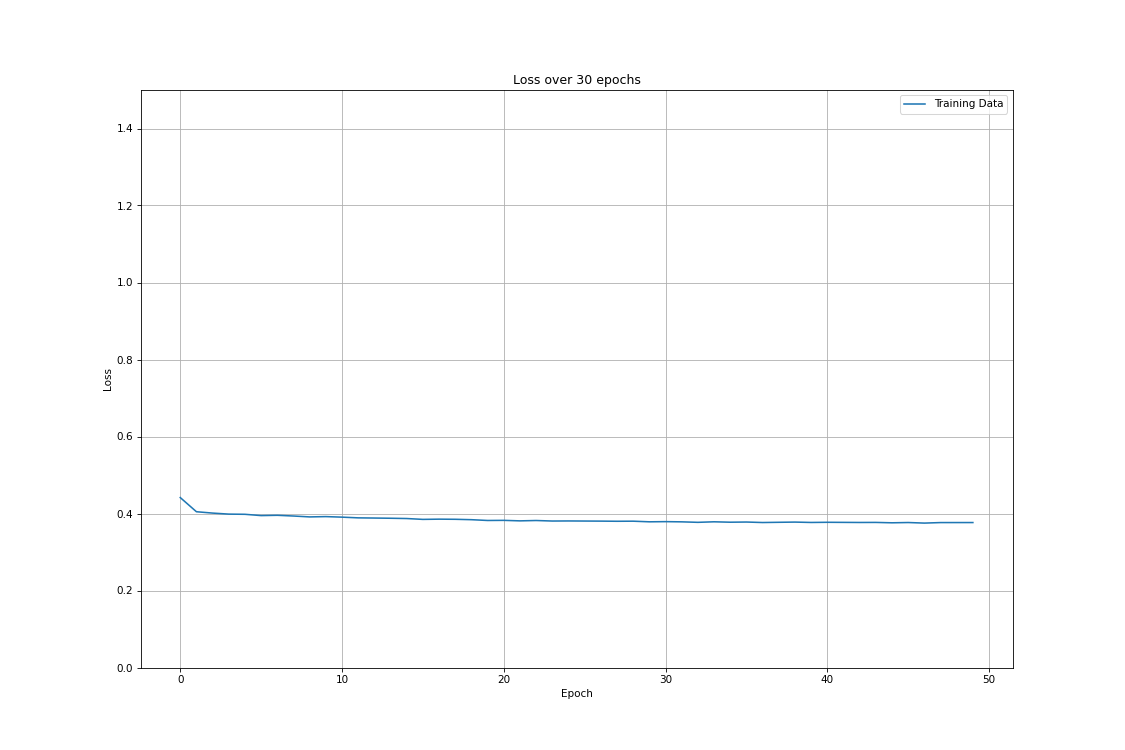

<IPython.core.display.Javascript object>


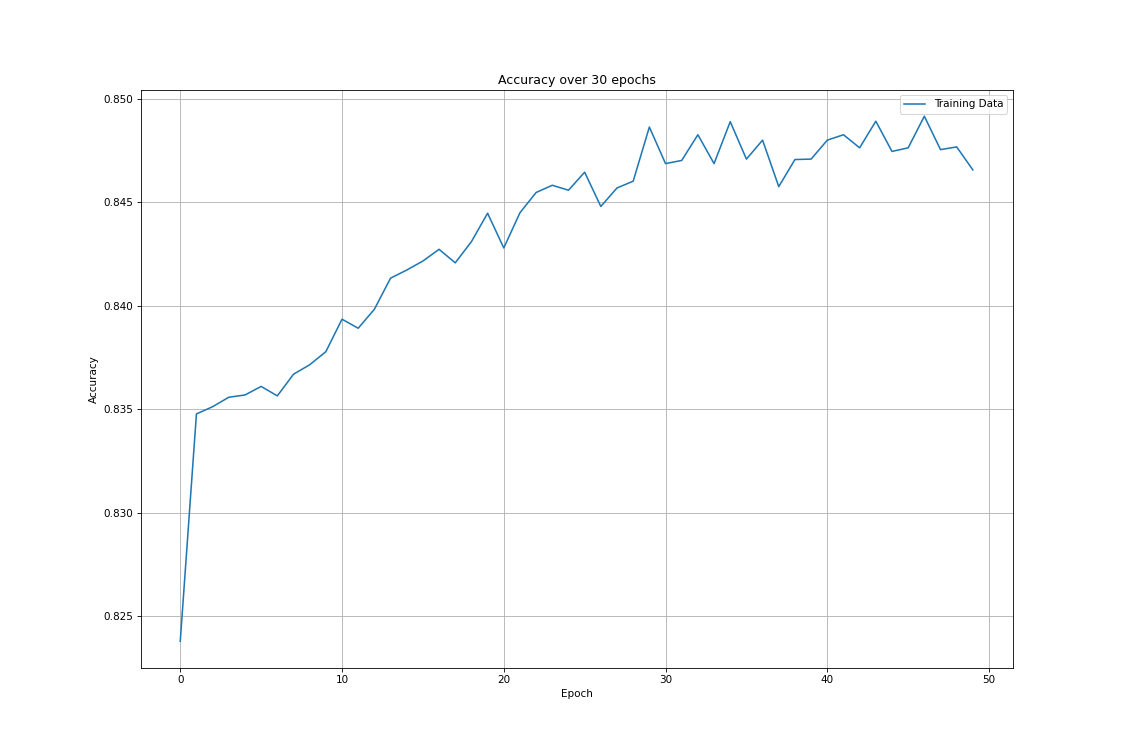

In [44]:
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'], label = "Training Data") #training loss
#plt.plot(history.history['val_loss'], label = "Test Data") #test loss
plt.xlabel("Epoch")
plt.grid(True, which="both")
plt.title("Loss over 30 epochs")
plt.ylim(0,1.5)
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.figure(figsize = (15,10))
plt.plot(history.history['accuracy'], label = "Training Data") #training loss
#plt.plot(history.history['val_accuracy'], label = "Test Data") #test loss
plt.legend()
plt.grid(True, which="both")
plt.title("Accuracy over 30 epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Function to Obtain Crossings for Any Data Once NN is Trained:

In [36]:
#savitzky–Golay filter

def SG_filter(data):
    return scipy.signal.savgol_filter(np.ndarray.flatten(data), 101, 2) # window size 31, polynomial order 3

In [37]:
def pred_cross(b, box_pts1, box_pts2):
    '''Predicted Bow-Shock Crossings

    Inputs: b (B-Total data), box_pts1 (smoothing-level of data), 
    boxpts2 (smoothing-level of prediction)
  
    Output: pred_int_grad (an arrray of 0s and 0.5s where the 0.5s are 
    the points of predicted bow-shock crossings)'''
  


    #smooth data:
    box = np.ones(box_pts1)/box_pts1
    smoothed_data = np.convolve(b, box, mode='same')

    #normalise smoothed data:
    norm_smth = smoothed_data/np.amax(smoothed_data)

    #prediction:
    X = pd.Series(norm_smth) #data
    prediction = model.predict(X)

    #smooth and "straighten" predictions to give rectangular form:
  
    box2 = np.ones(box_pts2)/box_pts2
    #pred_smth =  np.convolve(np.ndarray.flatten(prediction), box2, mode='same')
  
    pred_smth = SG_filter(prediction)
    #pred_smth = box_filter(prediction)
    straight = np.rint(pred_smth)

    #calculate grad to isolate crossings:
    #pred_int_grad = abs(np.gradient(straight))


    return np.ndarray.flatten(straight)

In [38]:
def orbit_pred(t, orb_beg, orb_end):
    '''


    '''

    #initial and final index or orbital period:
    ind_i = list(t).index(orb_beg) #initial
    ind_f = list(t).index(orb_end) #final
  
    #Pick arbitrary beggining and end of day times then determine
    #size of a single day's data: 
    dayi = list(time).index('2004-200T08:00:30') 
    dayf = list(time).index('2004-201T08:00:30')
    points_in1day = np.size(t[dayi:dayf]) 
    #size of 3 day's data:
    points_in3day = 3*points_in1day

    tot_pred = []
    while ind_i + points_in3day < ind_f:
        ind_i = ind_i + points_in3day
        pred = pred_cross(BTotal[ind_i - points_in3day :  ind_i], 25, 50)
      #pred = BTotal[ind_i - points_in3day - 1 :  ind_i]

      #print(ind_i)
      #print(pred)
  
        tot_pred.append(pred)

    predf = pred_cross(BTotal[ind_i : ind_f], 25, 50)

    #predf = BTotal[ind_i  : ind_f]
    #print(predf)
    tot_pred.append(predf)

    single_array = np.concatenate(tot_pred, axis=0)

    return single_array
  


## Predicting Crossings for 12 Orbits:

### Smooth Prediction Data for Higher Accuracy

We smooth the data before inputting into the NN for prediction because the it improves the accuracy. However, we train the NN with noisy data because it improves testing accuracy due to increase in data types.

In [39]:
def smooth(y, box_pts):
    '''Smoothed data
    Inputs: y (data), box_pts
    Output: smoothed data
    '''
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

### Revolution A

<IPython.core.display.Javascript object>


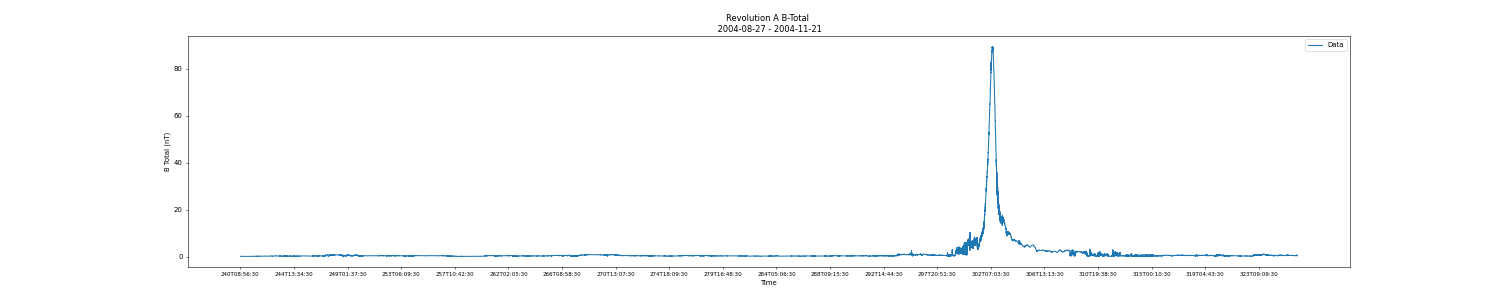

<IPython.core.display.Javascript object>


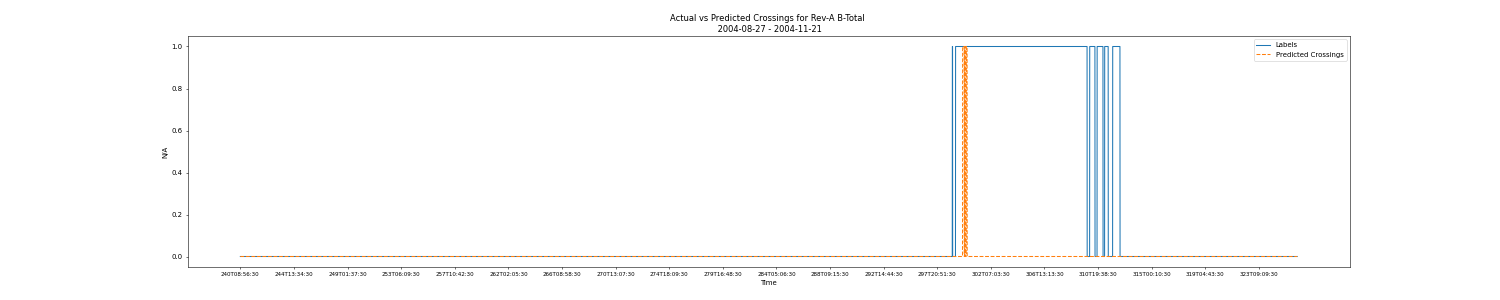

In [40]:
ind_reva_i = list(time).index('2004-240T08:56:30')
ind_reva_f = list(time).index('2004-326T08:41:30')


plt.figure(figsize=(30, 6))
plt.plot(time[ind_reva_i:ind_reva_f], BTotal[ind_reva_i:ind_reva_f], label="Data")

plt.title('Revolution A B-Total \n 2004-08-27 - 2004-11-21')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time[ind_reva_i:ind_reva_f],60*100)[0],
           labels = remove_year(tick_pace(time[ind_reva_i:ind_reva_f],60*100)[1]), fontsize= 8)

plt.show()




label_reva = label(time[ind_reva_i:ind_reva_f])
pred_reva = orbit_pred(time,'2004-240T08:56:30','2004-326T08:41:30')


plt.figure(figsize=(30, 6))
plt.plot(time[ind_reva_i:ind_reva_f], label_reva, label="Labels")
plt.plot(time[ind_reva_i:ind_reva_f], pred_reva, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Rev-A B-Total \n 2004-08-27 - 2004-11-21')
plt.xlabel('Time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time[ind_reva_i:ind_reva_f],60*100)[0],
           labels = remove_year(tick_pace(time[ind_reva_i:ind_reva_f],60*100)[1]), fontsize= 8)

plt.show()

### Revolution B

<IPython.core.display.Javascript object>


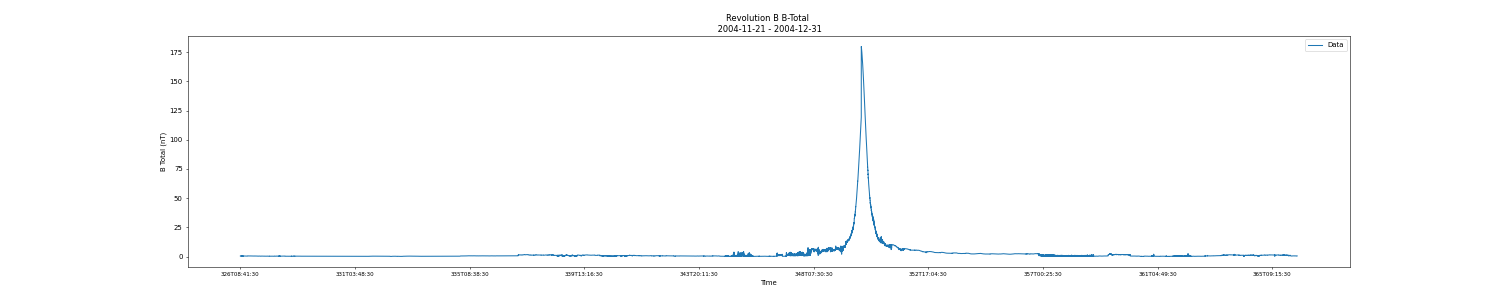

<IPython.core.display.Javascript object>


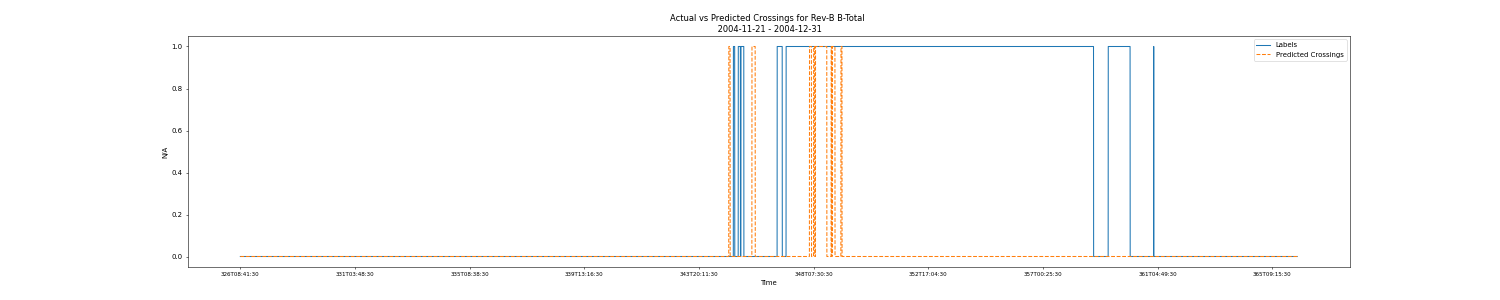

In [41]:
ind_revb_i = list(time).index('2004-326T08:41:30')
ind_revb_f = list(time).index('2004-366T07:02:30')


plt.figure(figsize=(30, 6))
plt.plot(time[ind_revb_i:ind_revb_f], BTotal[ind_revb_i:ind_revb_f], label="Data")

plt.title('Revolution B B-Total \n 2004-11-21 - 2004-12-31')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time[ind_revb_i:ind_revb_f],60*100)[0],
           labels = remove_year(tick_pace(time[ind_revb_i:ind_revb_f],60*100)[1]), fontsize= 8)

plt.show()




label_revb = label(time[ind_revb_i:ind_revb_f])
pred_revb = orbit_pred(time,'2004-326T08:41:30','2004-366T07:02:30')


plt.figure(figsize=(30, 6))
plt.plot(time[ind_revb_i:ind_revb_f], label_revb, label="Labels")
plt.plot(time[ind_revb_i:ind_revb_f], pred_revb, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Rev-B B-Total \n 2004-11-21 - 2004-12-31')
plt.xlabel('Time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time[ind_revb_i:ind_revb_f],60*100)[0],
           labels = remove_year(tick_pace(time[ind_revb_i:ind_revb_f],60*100)[1]), fontsize= 8)

plt.show()

### Revolution C

In [36]:
ind_revc_i = list(time).index('2004-366T07:02:30')
ind_revc_f = list(time05).index('2005-032T03:25:30')


time_revc = [] 
BTotal_revc = []

time_revc.append(time[ind_revc_i:])
time_revc.append(time05[:ind_revc_f])

BTotal_revc.append(BTotal[ind_revc_i:])
BTotal_revc.append(BTotal05[:ind_revc_f])

t_revc = np.concatenate(time_revc)
BT_revc = np.concatenate(BTotal_revc)

tot_time = []
tot_time.append(time)
tot_time.append(time05)

t_tot = np.concatenate(tot_time)

<IPython.core.display.Javascript object>


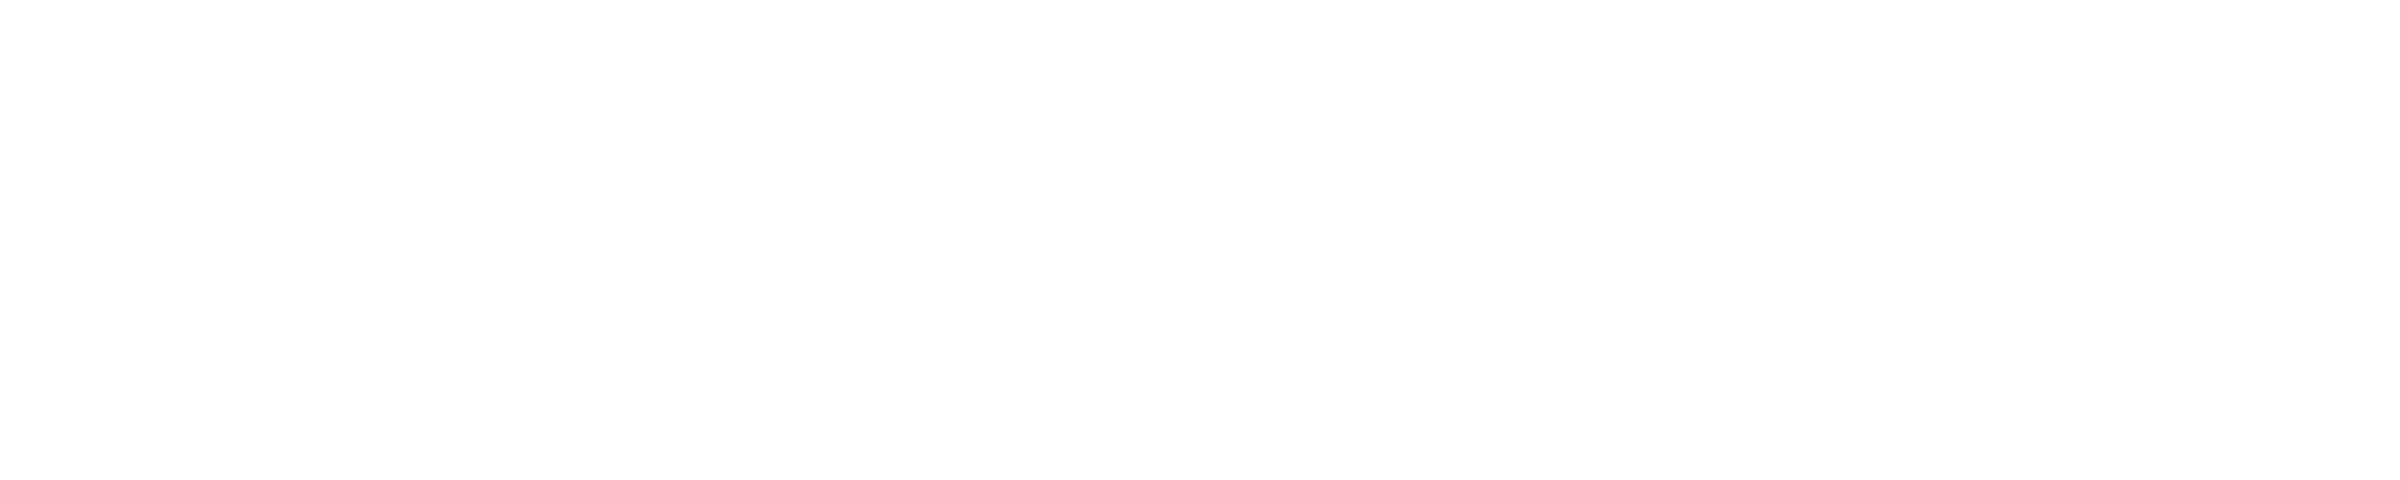

ValueError: v cannot be empty

In [37]:
plt.figure(figsize=(30, 6))
plt.plot(t_revc, BT_revc, label="Data")

plt.title('Revolution C B-Total \n 2004-12-31 - 2005-02-01')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(t_revc,60*100)[0],
           labels = remove_year(tick_pace(t_revc,60*100)[1]), fontsize= 8)

plt.show()




label_revc = label(t_revc)
pred_revc = orbit_pred(t_tot,'2004-366T07:02:30','2005-032T03:25:30')


plt.figure(figsize=(30, 6))
plt.plot(t_revc, label_revc, label="Labels")
plt.plot(t_revc, pred_revc, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Rev-C B-Total \n 2004-12-31 - 2005-02-01')
plt.xlabel('Time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(t_revc,60*100)[0],
           labels = remove_year(tick_pace(t_revc,60*100)[1]), fontsize= 8)

plt.show()


### Apoapsis 3

<IPython.core.display.Javascript object>


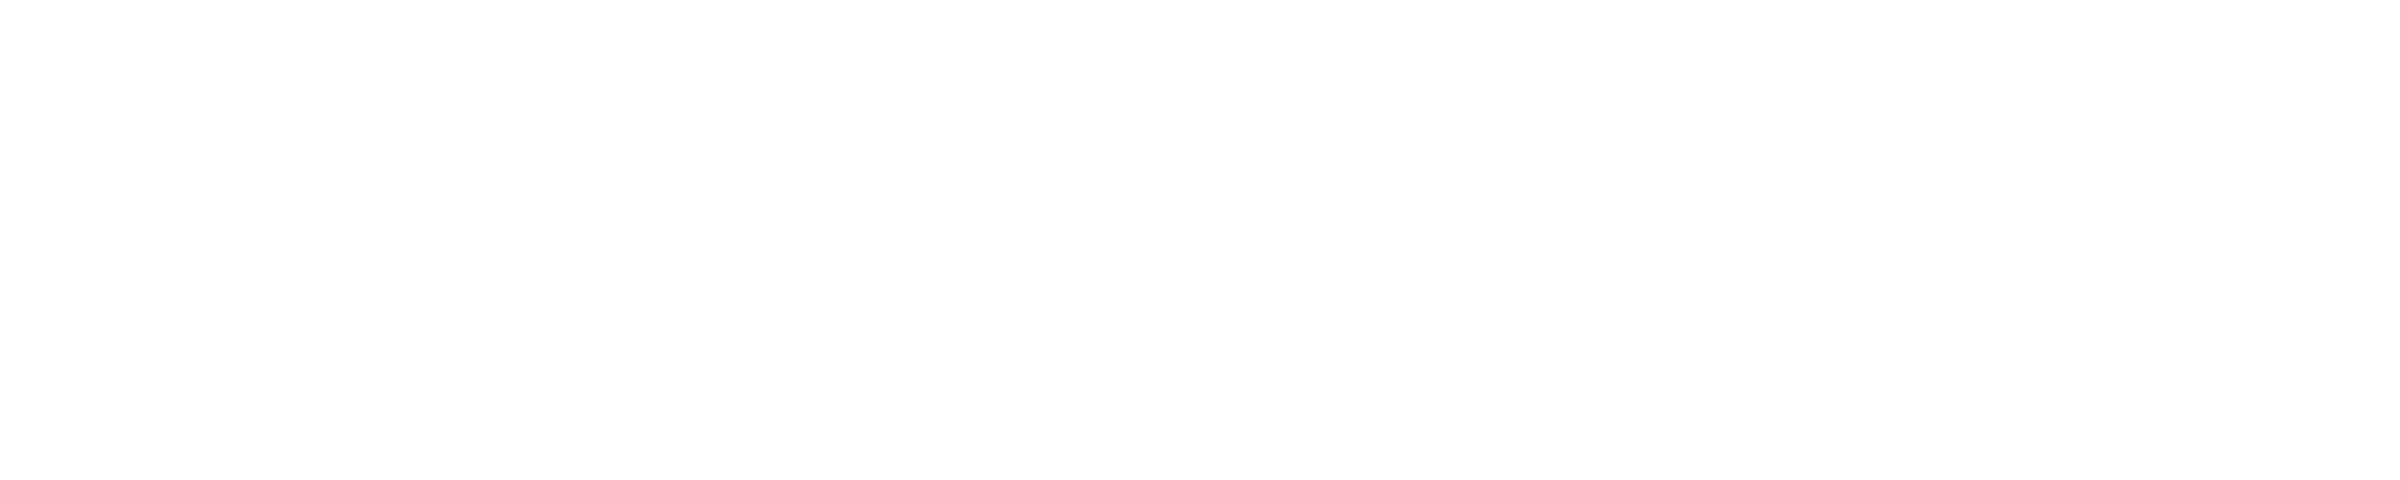

<IPython.core.display.Javascript object>


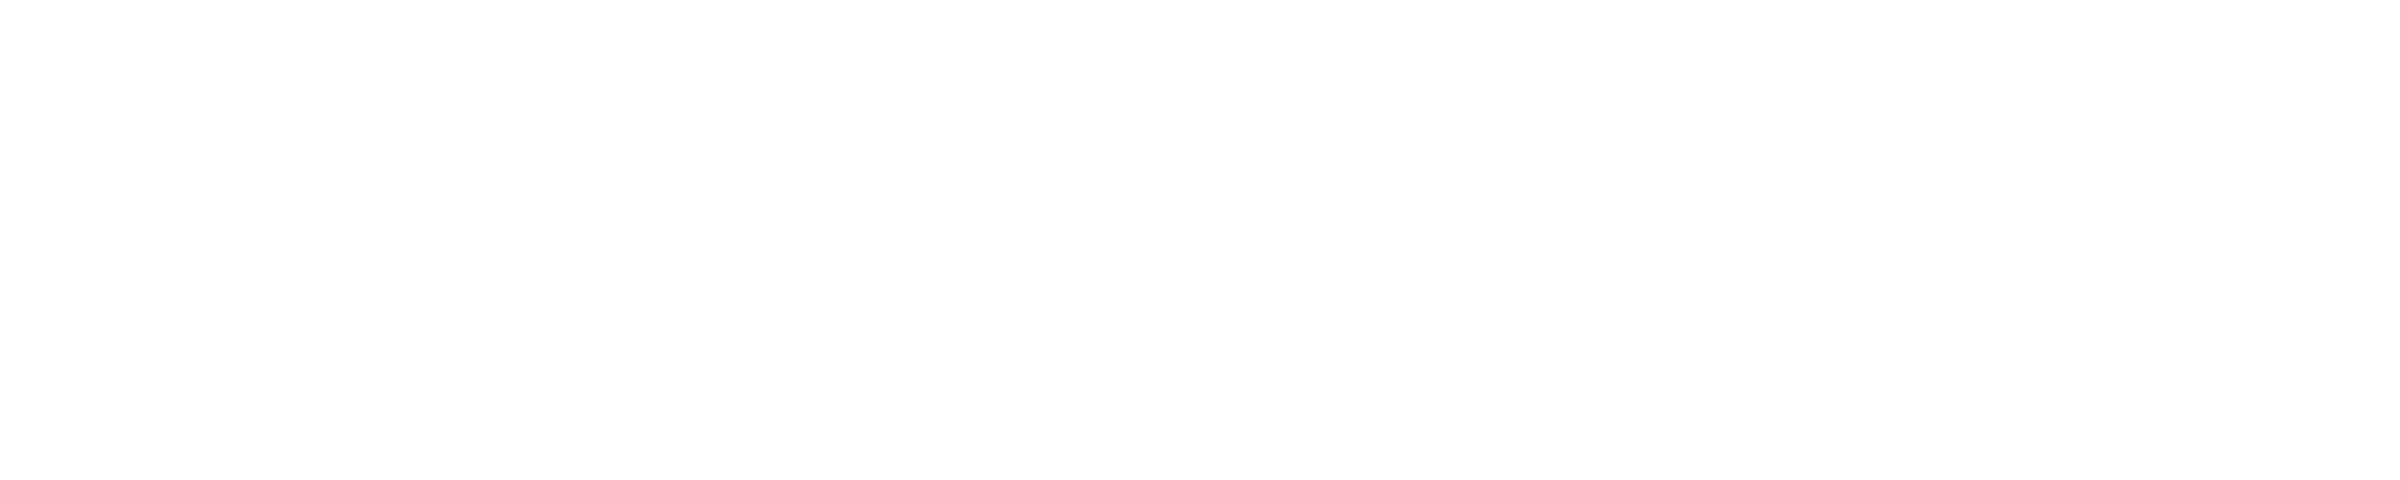

In [32]:
ind_ap3_i = list(time05).index('2005-032T03:25:30')
ind_ap3_f = list(time05).index('2005-058T06:19:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap3_i:ind_ap3_f], BTotal05[ind_ap3_i:ind_ap3_f], label="Data")

plt.title('Apoapsis 3 B-Total \n 2005-02-01 - 2005-02-27')
plt.xlabel('time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap3_i:ind_ap3_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap3_i:ind_ap3_f],60*25)[1]), fontsize= 8)

plt.show()




label_ap3 = label(time05[ind_ap3_i:ind_ap3_f])
pred_ap3 = orbit_pred(time05,'2005-032T03:25:30','2005-058T06:19:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap3_i:ind_ap3_f], label_ap3, label="Labels")
plt.plot(time05[ind_ap3_i:ind_ap3_f], pred_ap3, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Apoapsis 3 B-Total \n 2005-02-01 - 2005-02-27')
plt.xlabel('time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap3_i:ind_ap3_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap3_i:ind_ap3_f],60*25)[1]), fontsize= 8)

plt.show()

### Apoapsis 4

<IPython.core.display.Javascript object>


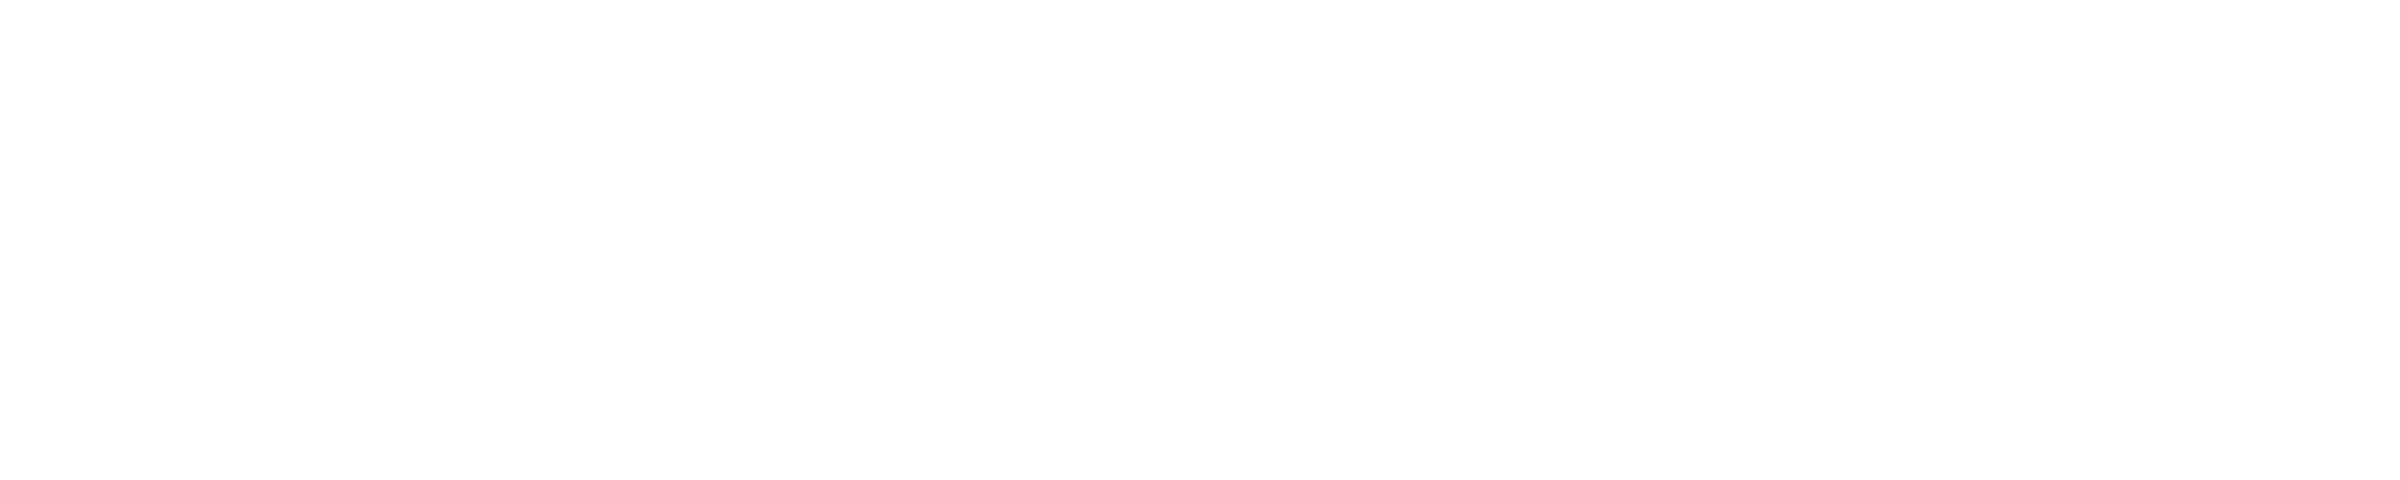

<IPython.core.display.Javascript object>


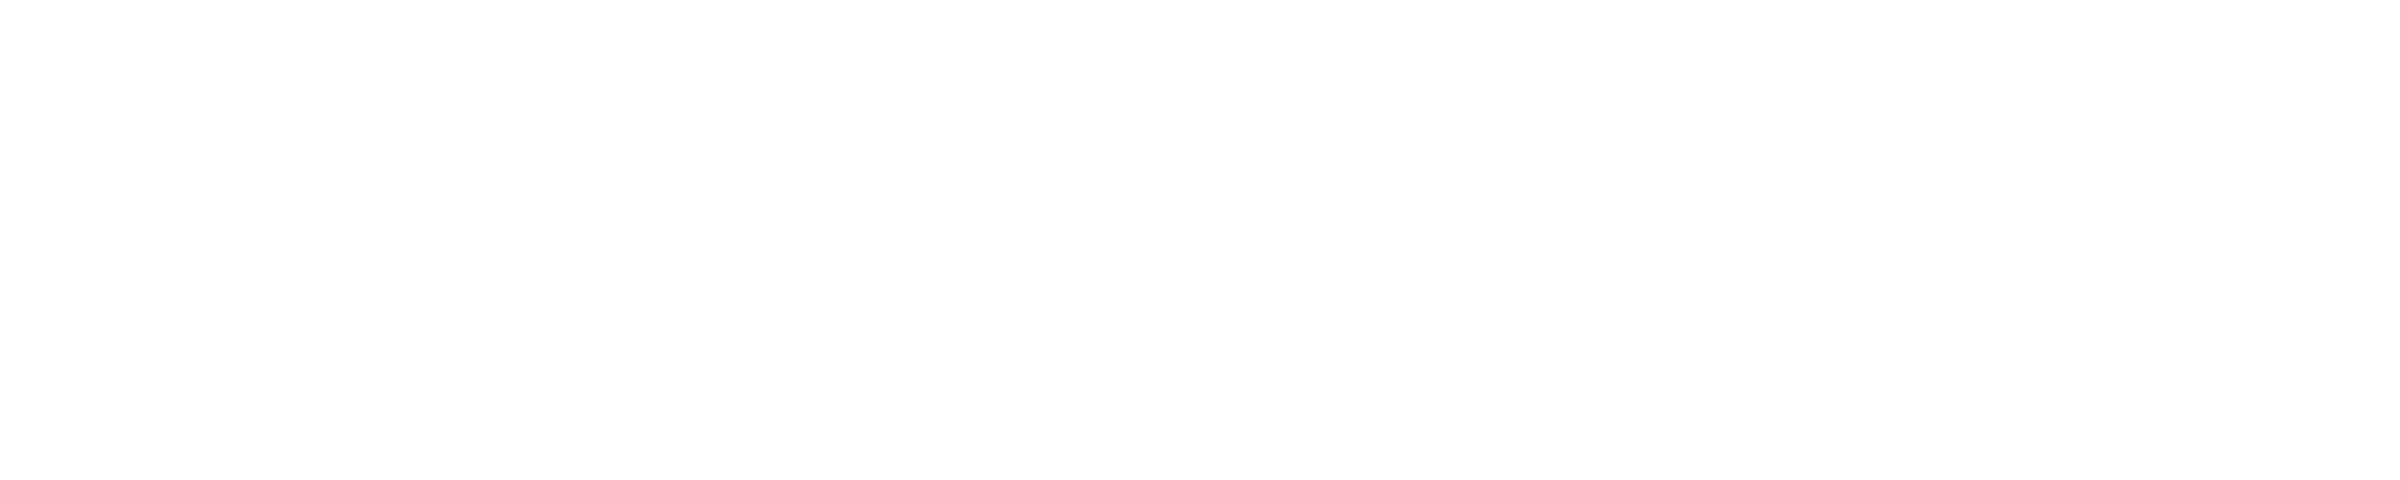

In [33]:
ind_ap4_i = list(time05).index('2005-058T06:19:30')
ind_ap4_f = list(time05).index('2005-078T17:34:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap4_i:ind_ap4_f], BTotal05[ind_ap4_i:ind_ap4_f], label="Data")

plt.title('Apoapsis 4 B-Total \n 2005-02-27 - 2005-03-19')
plt.xlabel('time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap4_i:ind_ap4_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap4_i:ind_ap4_f],60*25)[1]), fontsize= 8)

plt.show()




label_ap4 = label(time05[ind_ap4_i:ind_ap4_f])
pred_ap4 = orbit_pred(time05,'2005-058T06:19:30','2005-078T17:34:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap4_i:ind_ap4_f], label_ap4, label="Labels")
plt.plot(time05[ind_ap4_i:ind_ap4_f], pred_ap4, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Apoapsis 4 B-Total \n 2005-02-27 - 2005-03-19')
plt.xlabel('time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap4_i:ind_ap4_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap4_i:ind_ap4_f],60*25)[1]), fontsize= 8)

plt.show()

### Apoapsis 5

<IPython.core.display.Javascript object>


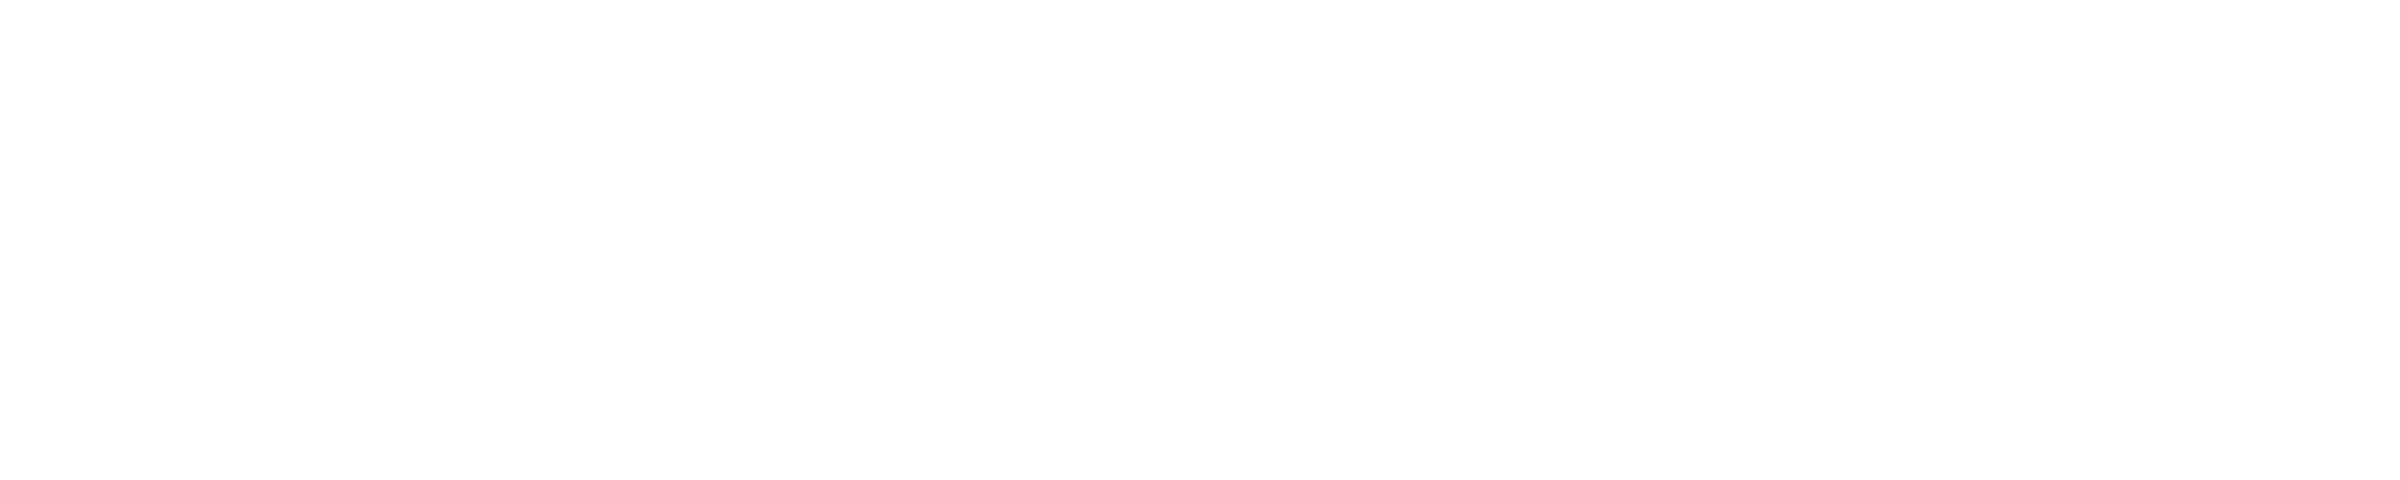

<IPython.core.display.Javascript object>


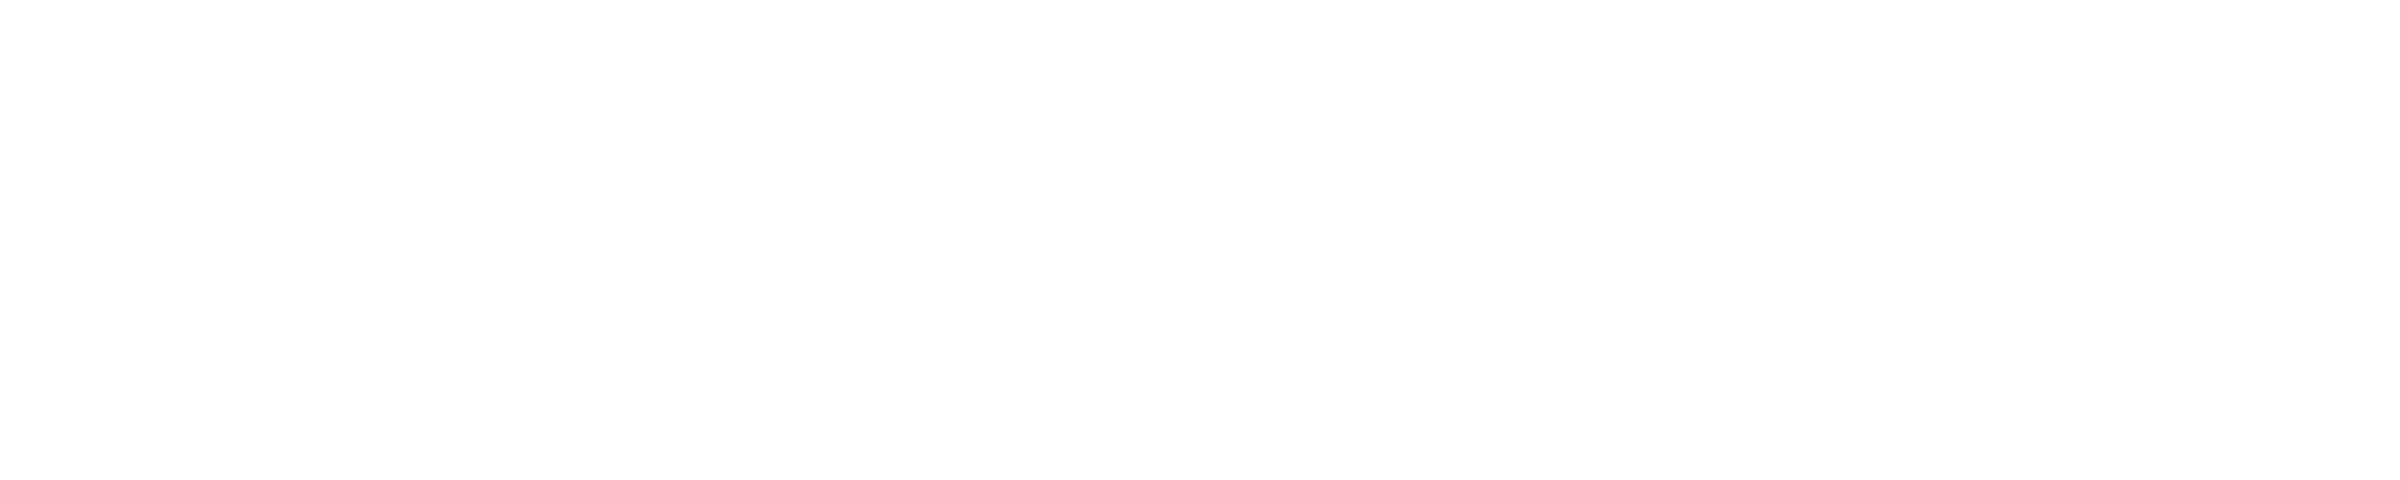

In [34]:
ind_ap5_i = list(time05).index('2005-078T17:34:30')
ind_ap5_f = list(time05).index('2005-096T23:32:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap5_i:ind_ap5_f], BTotal05[ind_ap5_i:ind_ap5_f], label="Data")

plt.title('Apoapsis 5 B-Total \n 2005-03-19 - 2005-04-06')
plt.xlabel('time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap5_i:ind_ap5_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap5_i:ind_ap5_f],60*25)[1]), fontsize= 8)

plt.show()




label_ap5 = label(time05[ind_ap5_i:ind_ap5_f])
pred_ap5 = orbit_pred(time05,'2005-078T17:34:30','2005-096T23:32:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap5_i:ind_ap5_f], label_ap5, label="Labels")
plt.plot(time05[ind_ap5_i:ind_ap5_f], pred_ap5, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Apoapsis 5 B-Total \n 2005-03-19 - 2005-04-06')
plt.xlabel('time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap5_i:ind_ap5_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap5_i:ind_ap5_f],60*25)[1]), fontsize= 8)

plt.show()

### Apoapsis 6

<IPython.core.display.Javascript object>


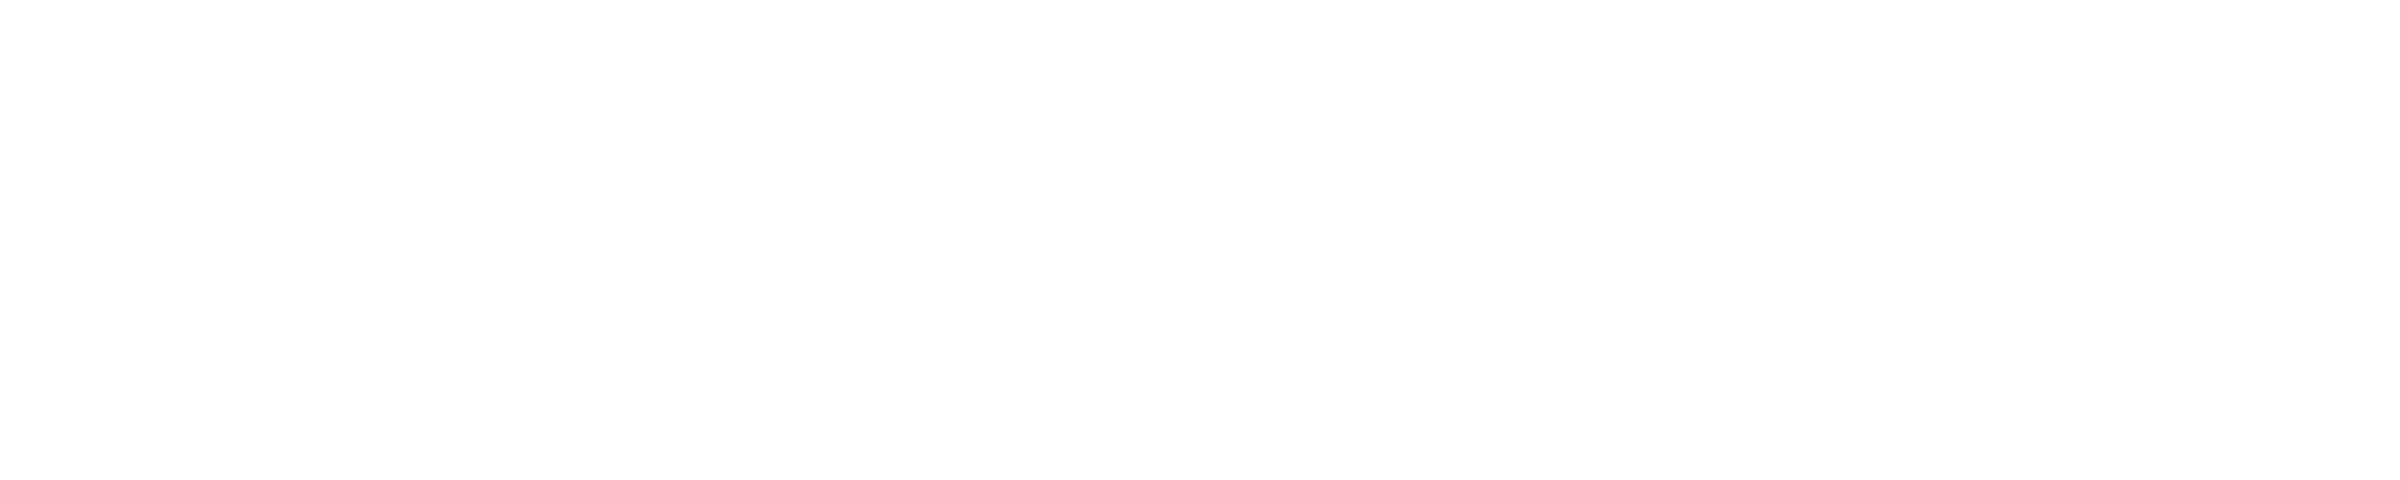

<IPython.core.display.Javascript object>


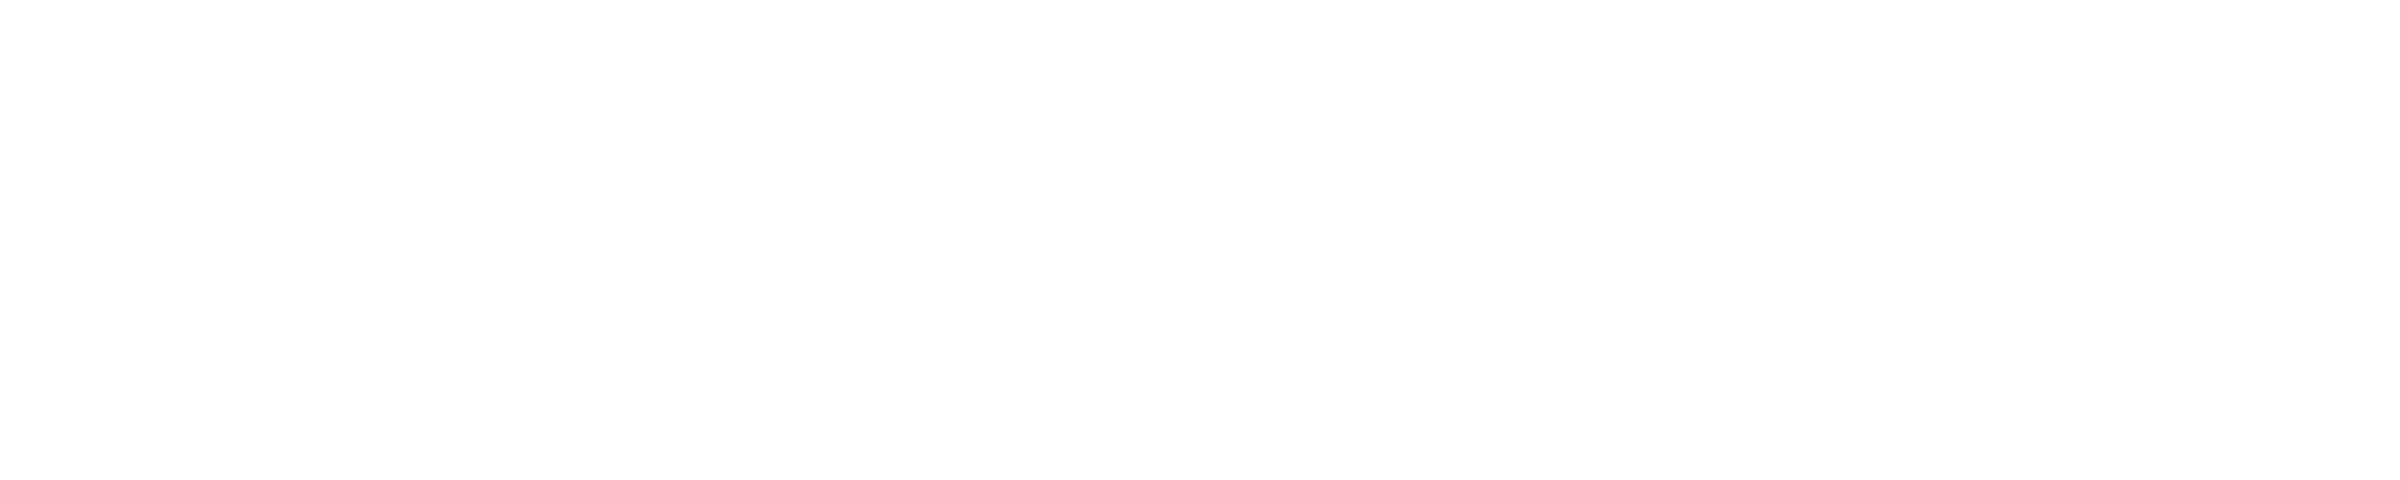

In [35]:
ind_ap6_i = list(time05).index('2005-096T23:32:30')
ind_ap6_f = list(time05).index('2005-113T23:32:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap6_i:ind_ap6_f], BTotal05[ind_ap6_i:ind_ap6_f], label="Data")

plt.title('Apoapsis 6 B-Total \n 2005-04-06 - 2005-04-23')
plt.xlabel('time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap6_i:ind_ap6_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap6_i:ind_ap6_f],60*25)[1]), fontsize= 8)

plt.show()




label_ap6 = label(time05[ind_ap6_i:ind_ap6_f])
pred_ap6 = orbit_pred(time05,'2005-096T23:32:30','2005-113T23:32:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap6_i:ind_ap6_f], label_ap6, label="Labels")
plt.plot(time05[ind_ap6_i:ind_ap6_f], pred_ap6, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Apoapsis 6 B-Total \n 2005-04-06 - 2005-04-23')
plt.xlabel('time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap6_i:ind_ap6_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap6_i:ind_ap6_f],60*25)[1]), fontsize= 8)

plt.show()

### Apoapsis 7

In [ ]:
ind_ap7_i = list(time05).index('2005-113T23:32:30')
ind_ap7_f = list(time05).index('2005-132T03:52:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap7_i:ind_ap7_f], BTotal05[ind_ap7_i:ind_ap7_f], label="Data")

plt.title('Apoapsis 7 B-Total \n 2005-04-23 - 2005-05-12')
plt.xlabel('time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis tim:
plt.xticks(ticks=tick_pace(time05[ind_ap7_i:ind_ap7_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap7_i:ind_ap7_f],60*25)[1]), fontsize= 8)

plt.show()




label_ap7 = label(time05[ind_ap7_i:ind_ap7_f])
pred_ap7 = orbit_pred(time05,'2005-113T23:32:30','2005-132T03:52:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap7_i:ind_ap7_f], label_ap7, label="Labels")
plt.plot(time05[ind_ap7_i:ind_ap7_f], pred_ap7, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Apoapsis 7 B-Total \n 2005-04-23 - 2005-05-12')
plt.xlabel('time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap7_i:ind_ap7_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap7_i:ind_ap7_f],60*25)[1]), fontsize= 8)

plt.show()

### Apoapsis 8

<IPython.core.display.Javascript object>


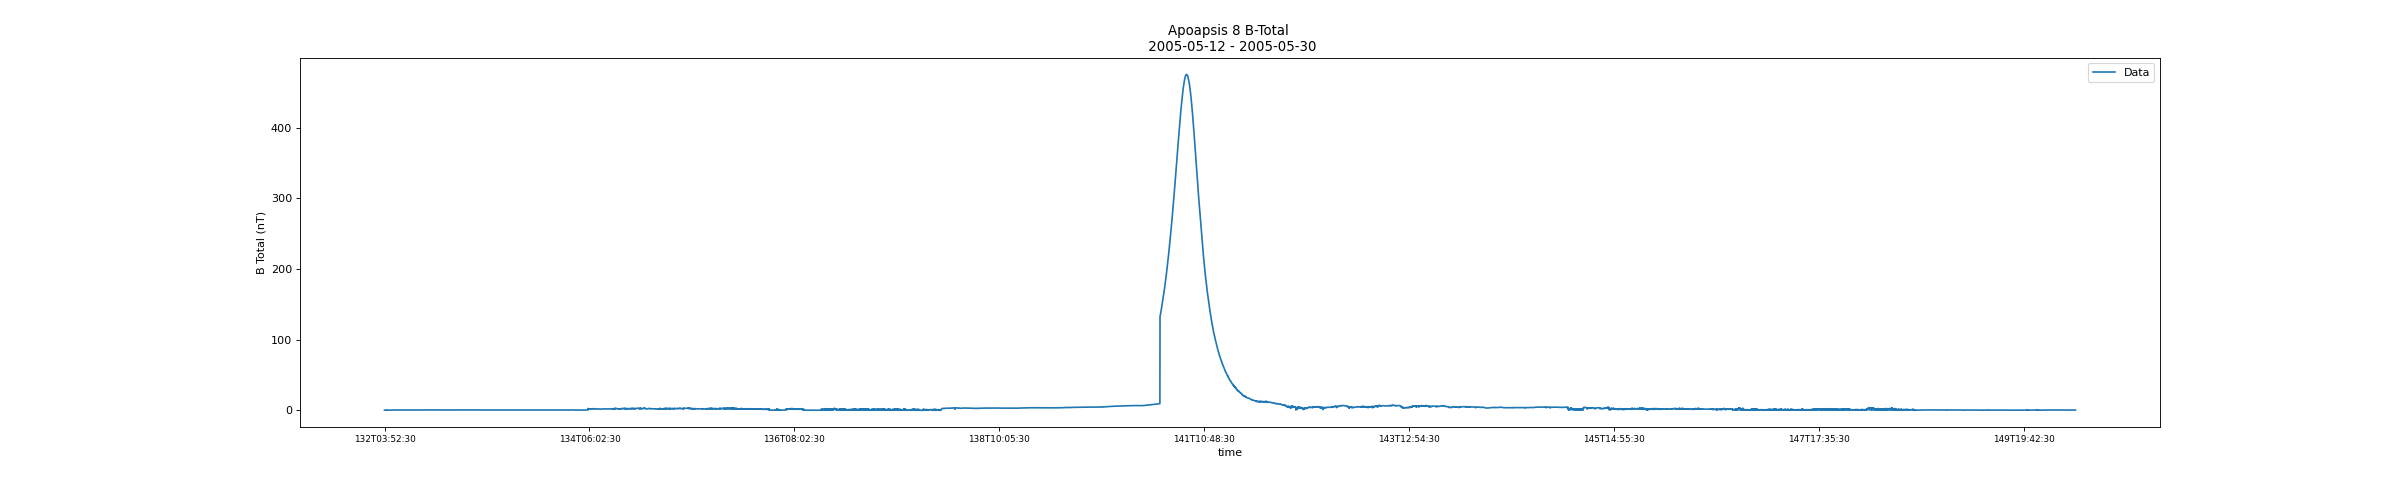

<IPython.core.display.Javascript object>


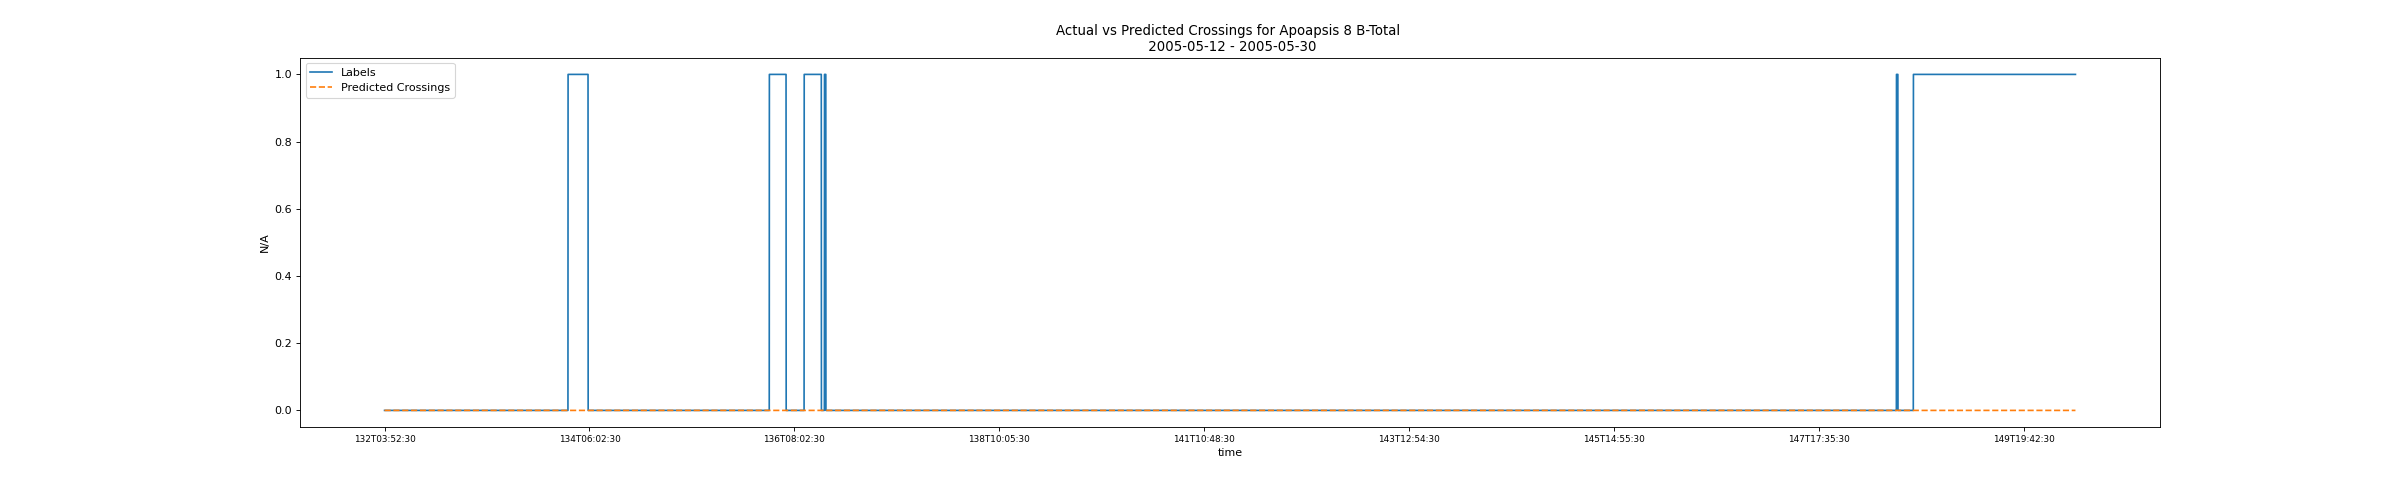

In [39]:
ind_ap8_i = list(time05).index('2005-132T03:52:30')
ind_ap8_f = list(time05).index('2005-150T08:21:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap8_i:ind_ap8_f], BTotal05[ind_ap8_i:ind_ap8_f], label="Data")

plt.title('Apoapsis 8 B-Total \n 2005-05-12 - 2005-05-30')
plt.xlabel('time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap8_i:ind_ap8_f],60*50)[0],
           labels = remove_year(tick_pace(time05[ind_ap8_i:ind_ap8_f],60*50)[1]), fontsize= 8)

plt.show()




label_ap8 = label(time05[ind_ap8_i:ind_ap8_f])
pred_ap8 = orbit_pred(time05,'2005-132T03:52:30','2005-150T08:21:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap8_i:ind_ap8_f], label_ap8, label="Labels")
plt.plot(time05[ind_ap8_i:ind_ap8_f], pred_ap8, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Apoapsis 8 B-Total \n 2005-05-12 - 2005-05-30')
plt.xlabel('time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap8_i:ind_ap8_f],60*50)[0],
           labels = remove_year(tick_pace(time05[ind_ap8_i:ind_ap8_f],60*50)[1]), fontsize= 8)

plt.show()

### Apoapsis 9

<IPython.core.display.Javascript object>


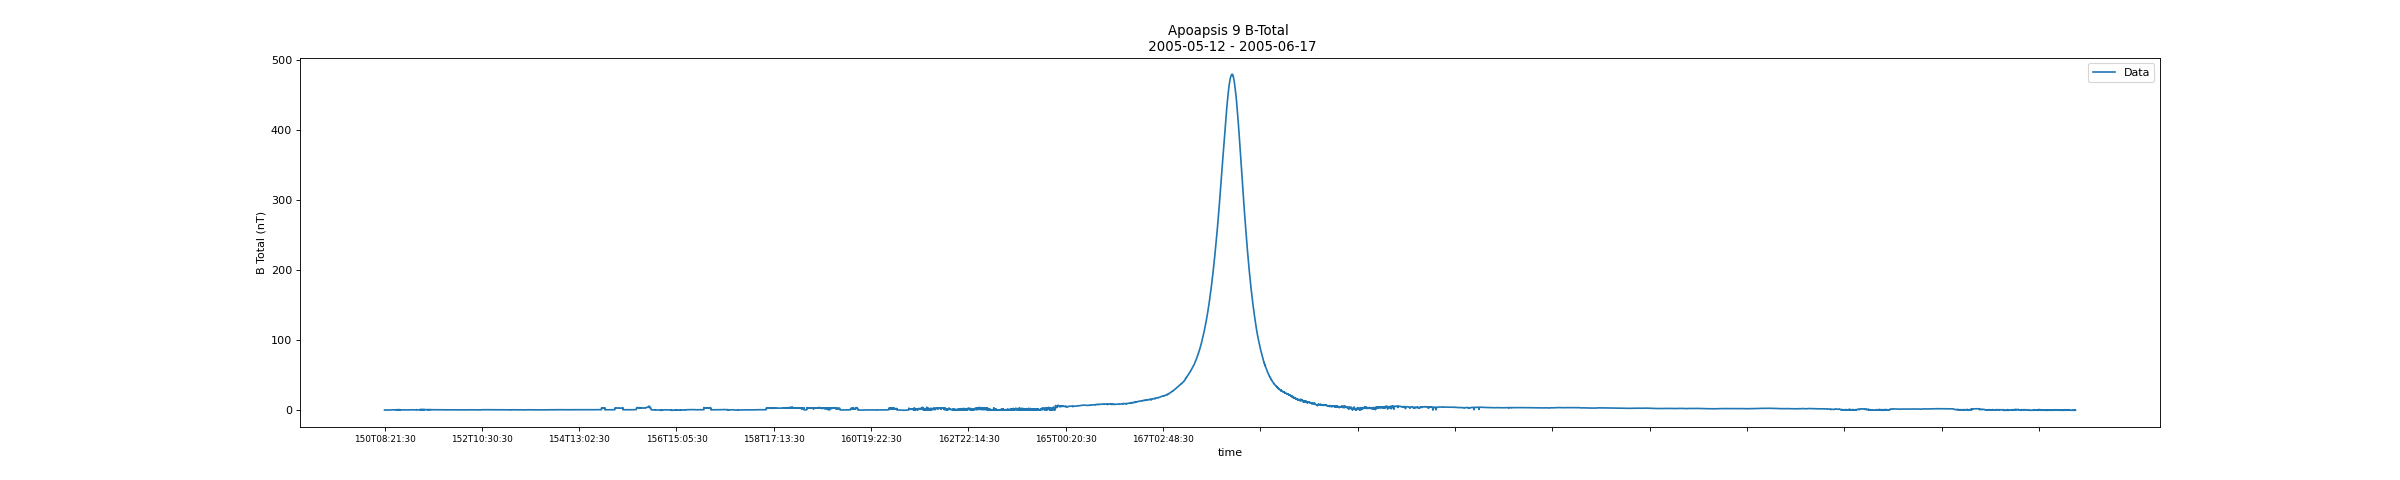

<IPython.core.display.Javascript object>


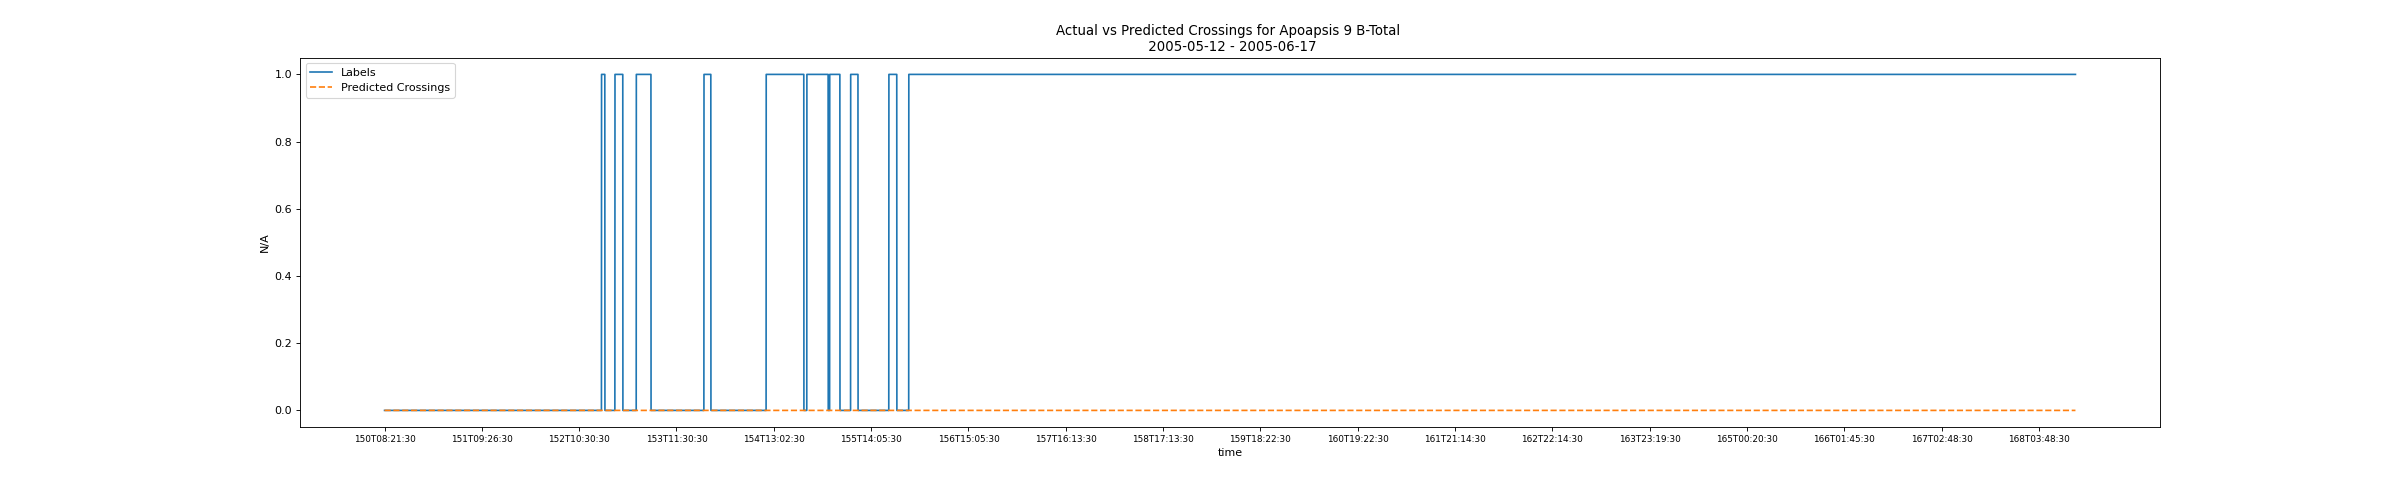

In [38]:
ind_ap9_i = list(time05).index('2005-150T08:21:30')
ind_ap9_f = list(time05).index('2005-168T13:12:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap9_i:ind_ap9_f], BTotal05[ind_ap9_i:ind_ap9_f], label="Data")

plt.title('Apoapsis 9 B-Total \n 2005-05-12 - 2005-06-17')
plt.xlabel('time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap9_i:ind_ap9_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap9_i:ind_ap9_f],60*50)[1]), fontsize= 8)

plt.show()




label_ap9 = label(time05[ind_ap9_i:ind_ap9_f])
pred_ap9 = orbit_pred(time05,'2005-150T08:21:30','2005-168T13:12:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap9_i:ind_ap9_f], label_ap9, label="Labels")
plt.plot(time05[ind_ap9_i:ind_ap9_f], pred_ap9, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Apoapsis 9 B-Total \n 2005-05-12 - 2005-06-17')
plt.xlabel('time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap9_i:ind_ap9_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap9_i:ind_ap9_f],60*25)[1]), fontsize= 8)

plt.show()

### Apoapsis 10

<IPython.core.display.Javascript object>


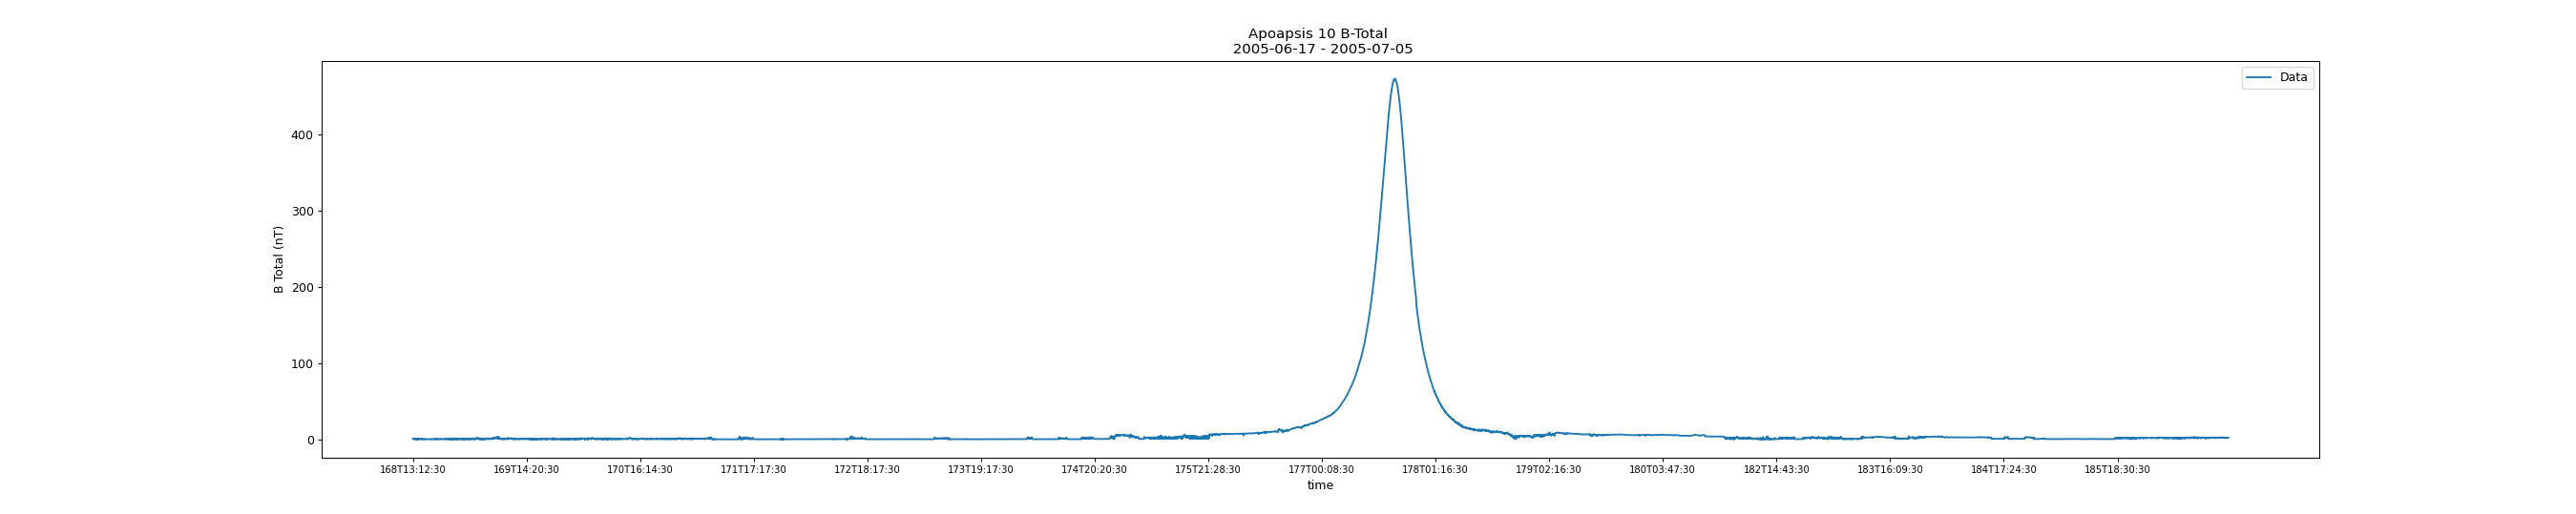

<IPython.core.display.Javascript object>


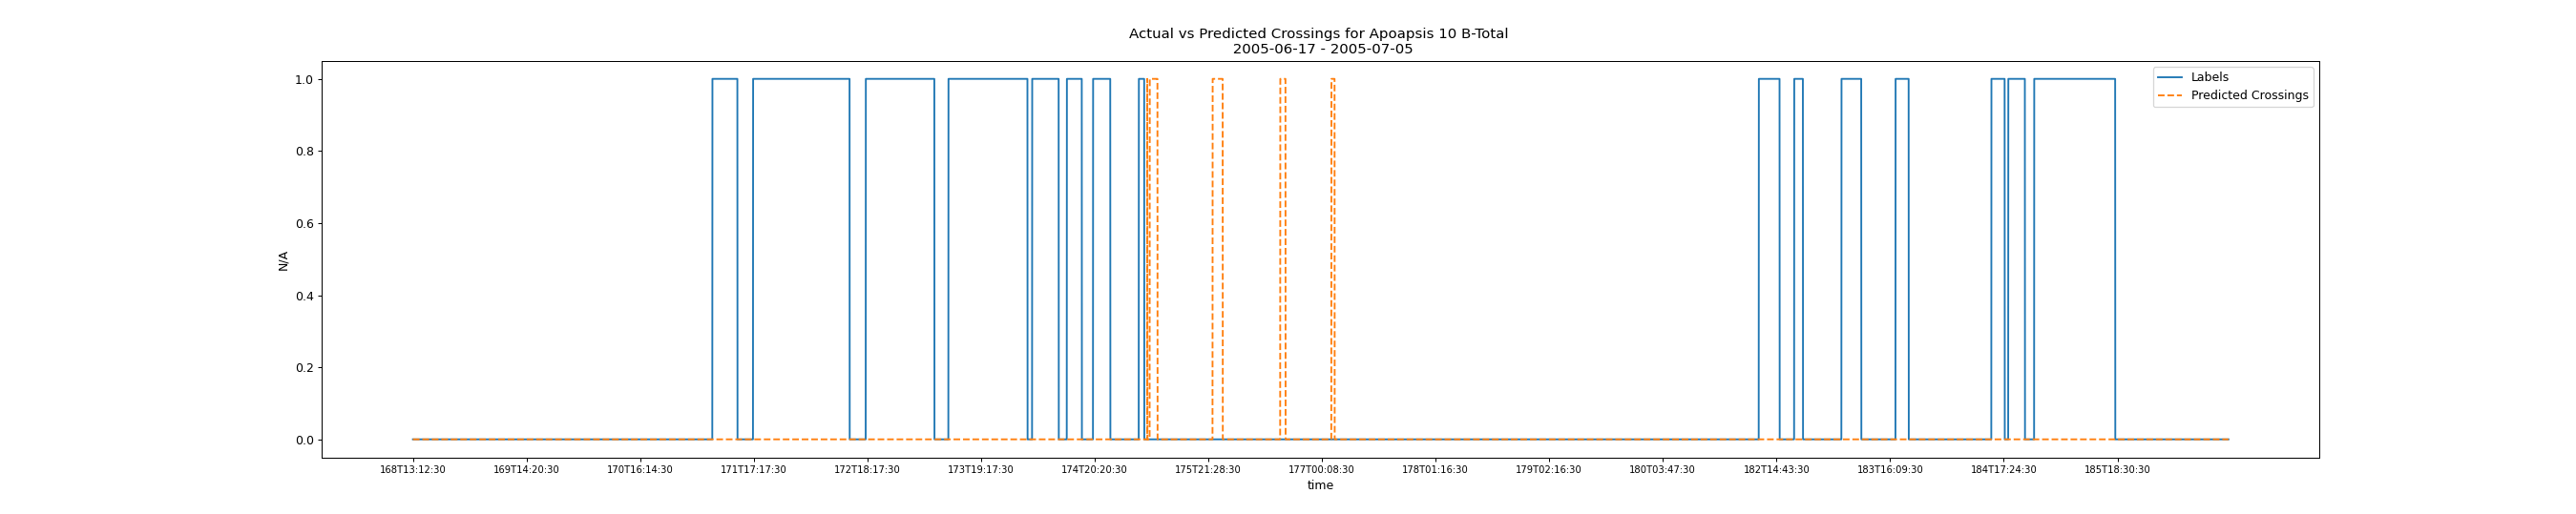

In [52]:
ind_ap10_i = list(time05).index('2005-168T13:12:30')
ind_ap10_f = list(time05).index('2005-186T18:57:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap10_i:ind_ap10_f], BTotal05[ind_ap10_i:ind_ap10_f], label="Data")

plt.title('Apoapsis 10 B-Total \n 2005-06-17 - 2005-07-05')
plt.xlabel('time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap10_i:ind_ap10_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap10_i:ind_ap10_f],60*25)[1]), fontsize= 8)

plt.show()




label_ap10 = label(time05[ind_ap10_i:ind_ap10_f])
pred_ap10 = orbit_pred(time05,'2005-168T13:12:30','2005-186T18:57:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap10_i:ind_ap10_f], label_ap10, label="Labels")
plt.plot(time05[ind_ap10_i:ind_ap10_f], pred_ap10, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Apoapsis 10 B-Total \n 2005-06-17 - 2005-07-05')
plt.xlabel('time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap10_i:ind_ap10_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap10_i:ind_ap10_f],60*25)[1]), fontsize= 8)

plt.show()

### Apoapsis 11

<IPython.core.display.Javascript object>


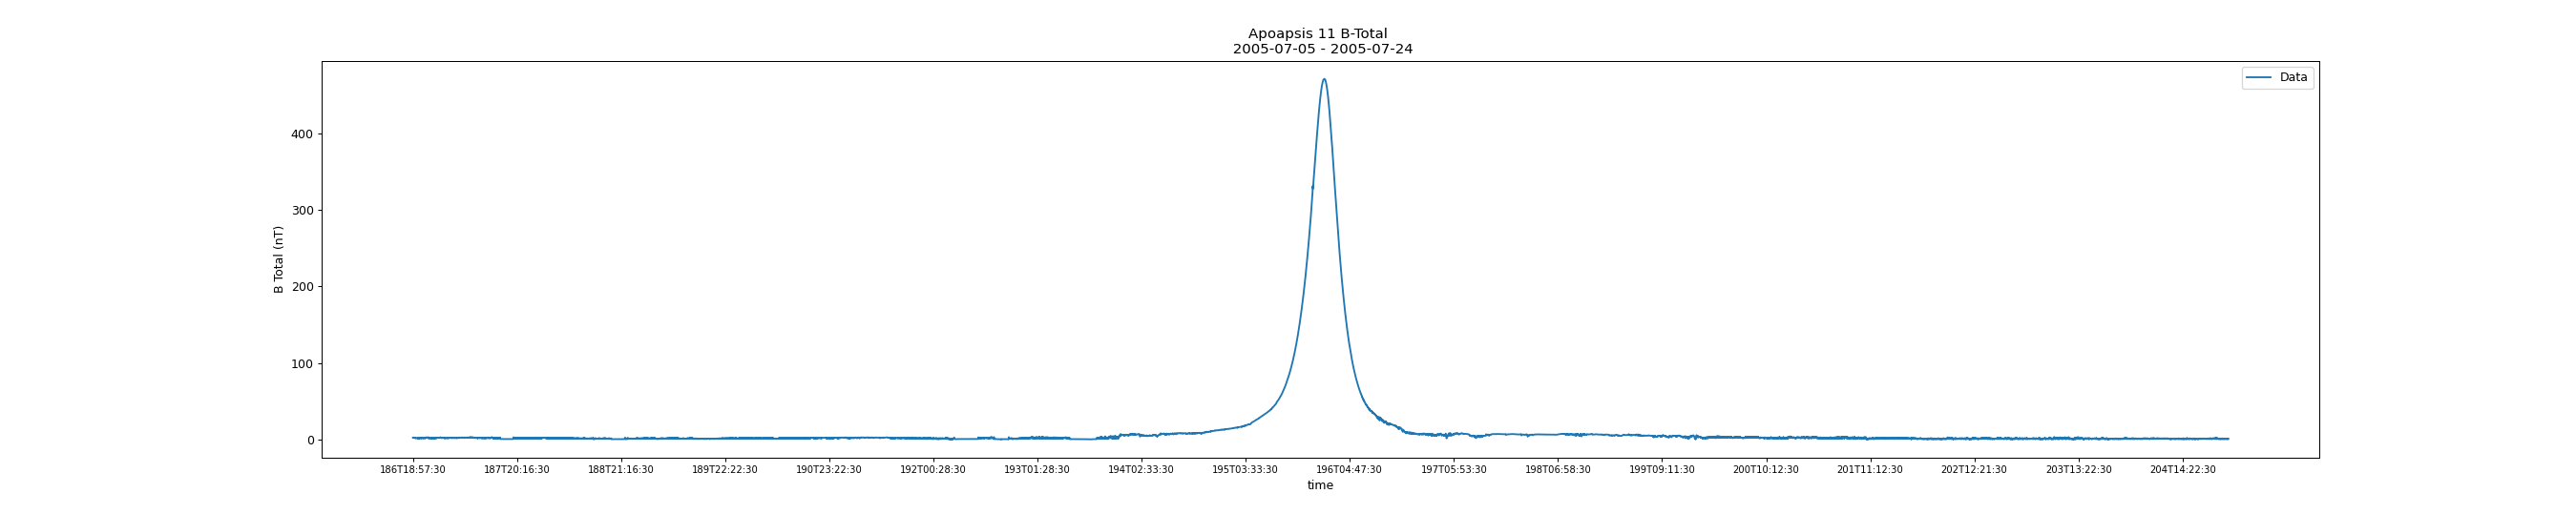

<IPython.core.display.Javascript object>


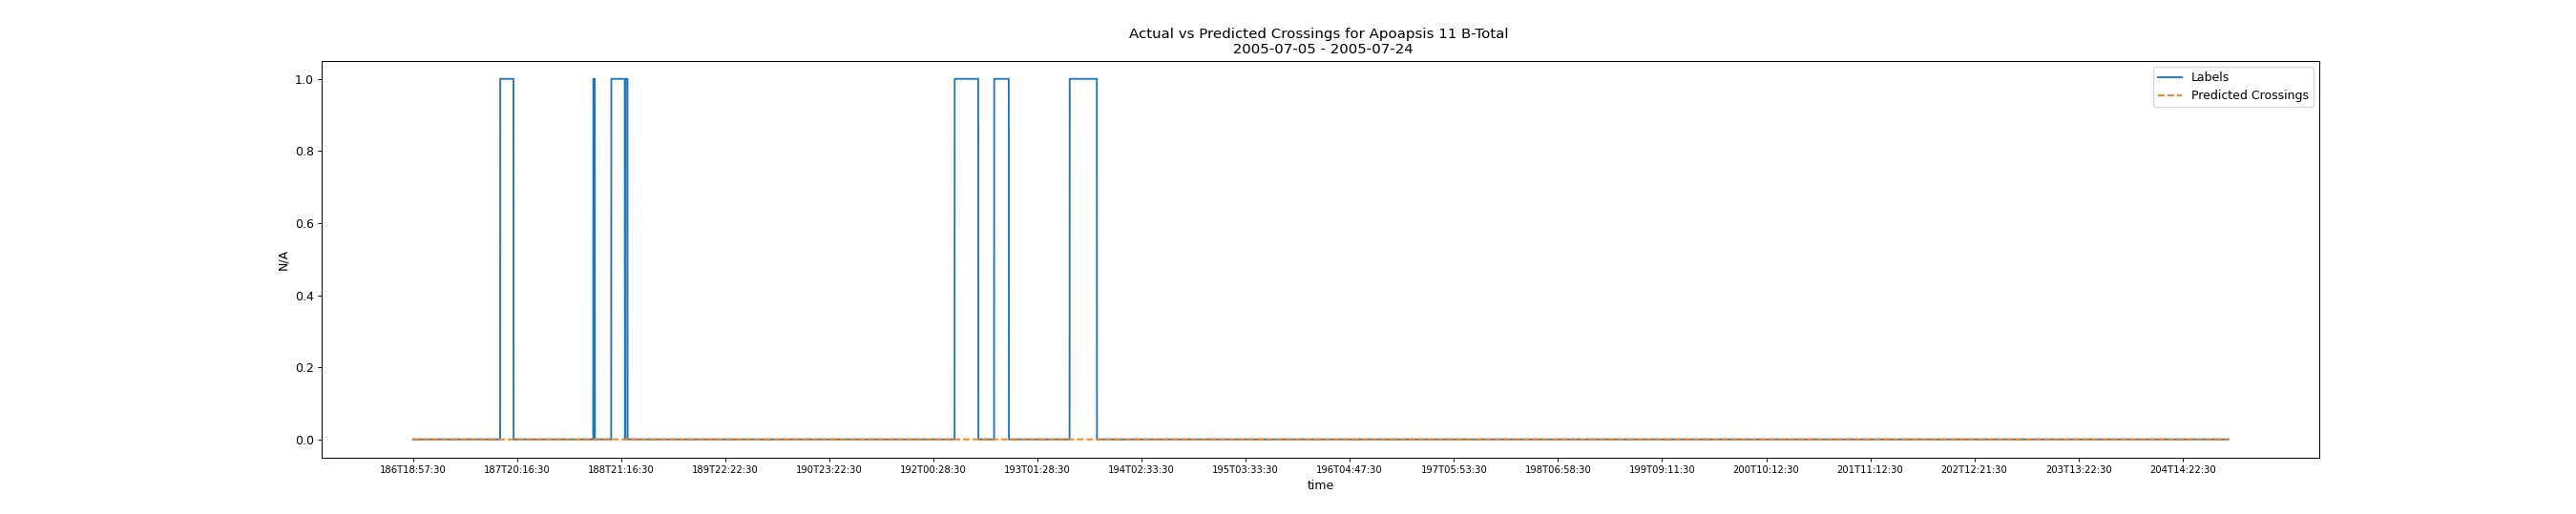

In [53]:
ind_ap11_i = list(time05).index('2005-186T18:57:30')
ind_ap11_f = list(time05).index('2005-205T01:58:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap11_i:ind_ap11_f], BTotal05[ind_ap11_i:ind_ap11_f], label="Data")

plt.title('Apoapsis 11 B-Total \n 2005-07-05 - 2005-07-24')
plt.xlabel('time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap11_i:ind_ap11_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap11_i:ind_ap11_f],60*25)[1]), fontsize= 8)

plt.show()




label_ap11 = label(time05[ind_ap11_i:ind_ap11_f])
pred_ap11 = orbit_pred(time05,'2005-186T18:57:30','2005-205T01:58:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap11_i:ind_ap11_f], label_ap11, label="Labels")
plt.plot(time05[ind_ap11_i:ind_ap11_f], pred_ap11, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Apoapsis 11 B-Total \n 2005-07-05 - 2005-07-24')
plt.xlabel('time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap11_i:ind_ap11_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap11_i:ind_ap11_f],60*25)[1]), fontsize= 8)

plt.show()

### Apoapsis 12

<IPython.core.display.Javascript object>


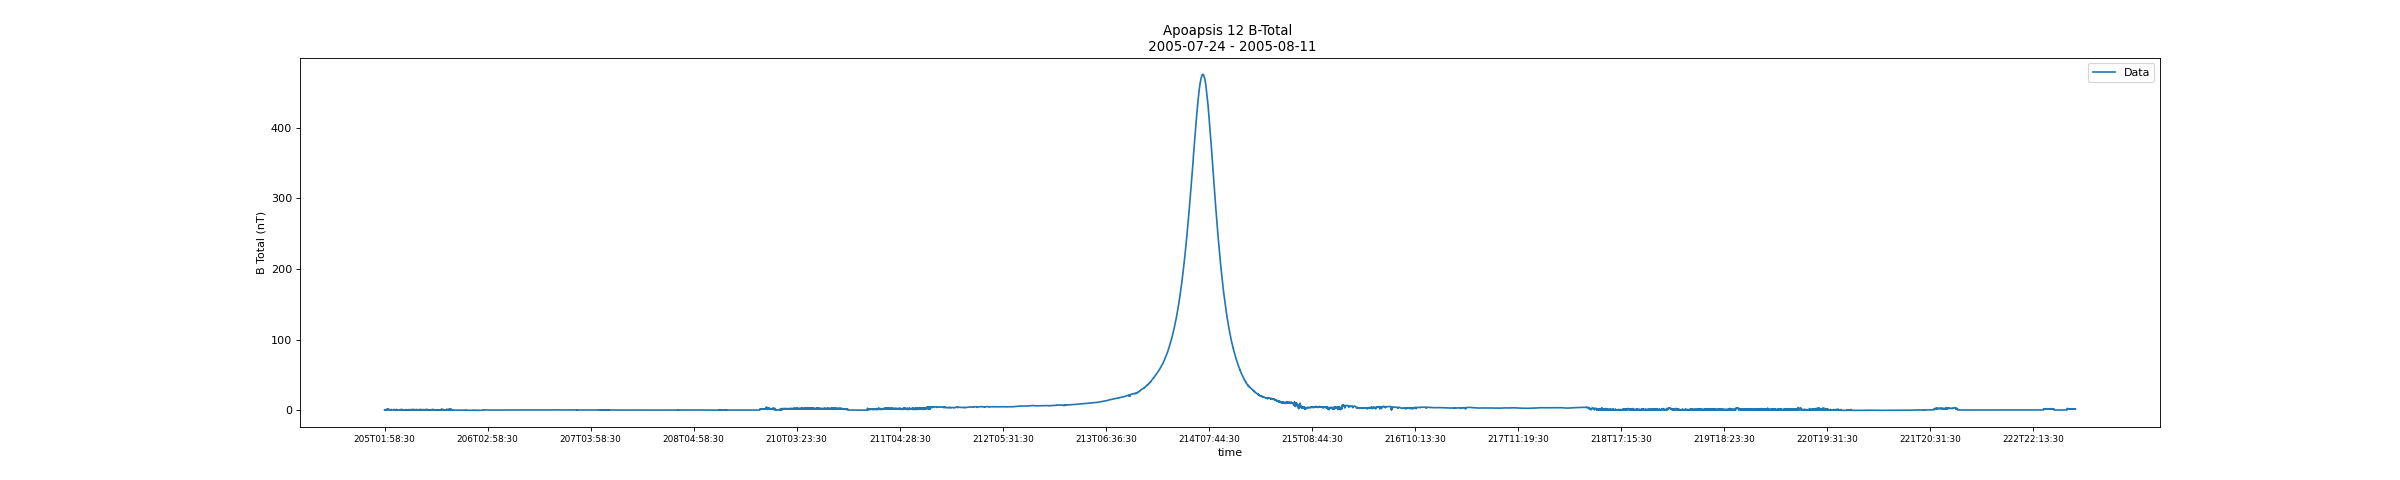

<IPython.core.display.Javascript object>


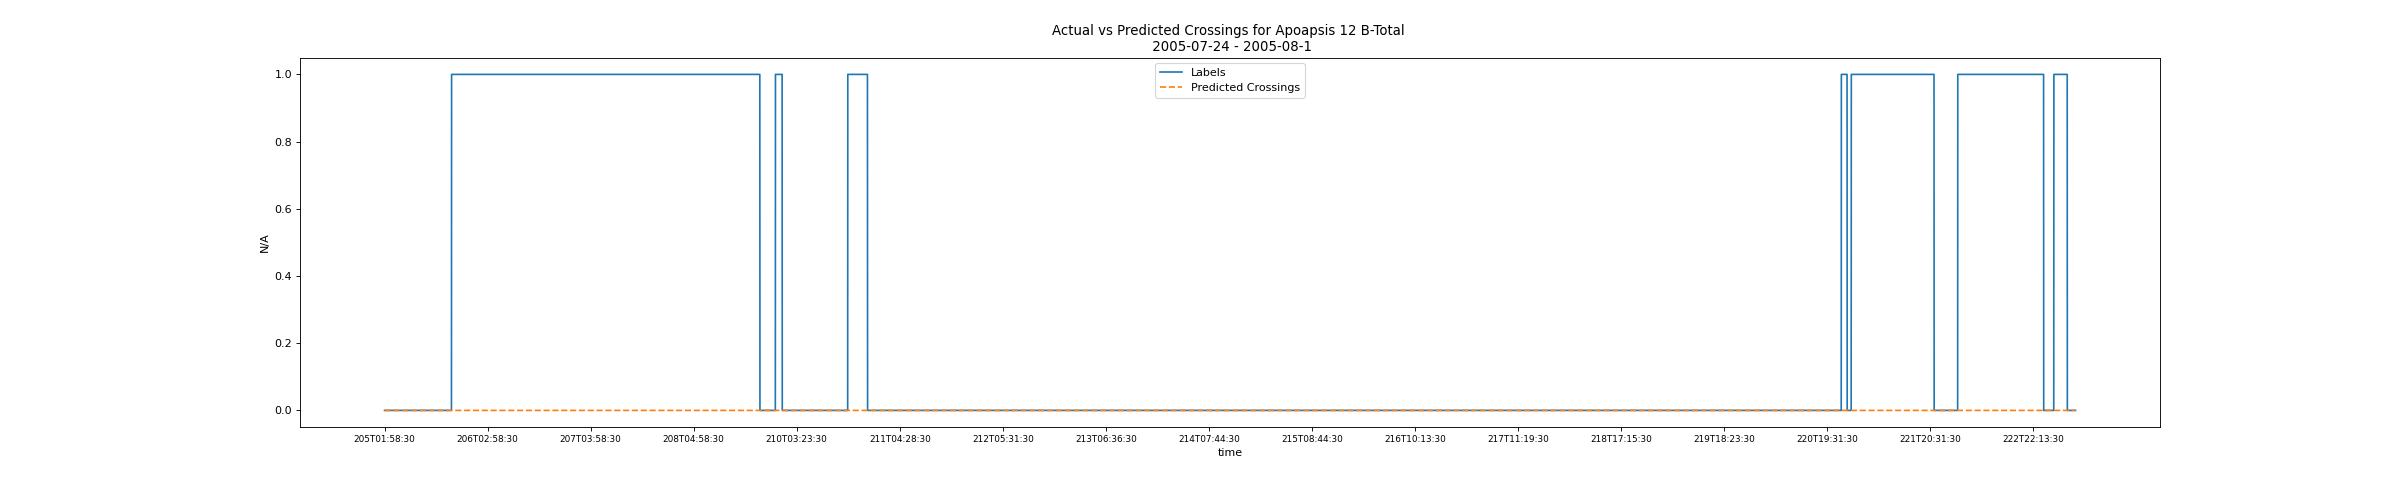

In [33]:
ind_ap12_i = list(time05).index('2005-205T01:58:30')
ind_ap12_f = list(time05).index('2005-223T08:30:30')



plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap12_i:ind_ap12_f], BTotal05[ind_ap12_i:ind_ap12_f], label="Data")

plt.title('Apoapsis 12 B-Total \n 2005-07-24 - 2005-08-11')
plt.xlabel('time')
plt.ylabel('B Total (nT)')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap12_i:ind_ap12_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap12_i:ind_ap12_f],60*25)[1]), fontsize= 8)

plt.show()





label_ap12 = label(time05[ind_ap12_i:ind_ap12_f])
pred_ap12 = orbit_pred(time05,'2005-205T01:58:30','2005-223T08:30:30')


plt.figure(figsize=(30, 6))
plt.plot(time05[ind_ap12_i:ind_ap12_f], label_ap12, label="Labels")
plt.plot(time05[ind_ap12_i:ind_ap12_f], pred_ap12, '--', label="Predicted Crossings")

plt.title('Actual vs Predicted Crossings for Apoapsis 12 B-Total \n 2005-07-24 - 2005-08-1')
plt.xlabel('time')
plt.ylabel('N/A')
plt.legend()

#format x-axis time:
plt.xticks(ticks=tick_pace(time05[ind_ap12_i:ind_ap12_f],60*25)[0],
           labels = remove_year(tick_pace(time05[ind_ap12_i:ind_ap12_f],60*25)[1]), fontsize= 8)

plt.show()